# 1. Introduction

Nama : Muhammad Erico Ricardo

Batch : FTDS-BSD-007

Latar Belakang :
AutoShop adalah sebuah aplikasi marketplace yang hanya menjual barang-barang yang berhubungan dengan automotif, Seperti Sabun mobil, Aksesoris, dan semacamnya. Demi meningkatkan kualitas aplikasi AutoShop, tim data analis dari AutoShop berusaha mengidentifikasi kemungkinan pelanggan AutoShop untuk berhenti menggunakan AutoShop dan bekerja sama dengan tim marketing untuk memberikan insentif atau bantuan pada pelanggan yang memiliki kemungkinan berhenti yang tinggi.

link hugging face : https://huggingface.co/spaces/EricoR/Milestone2

Sebagai data Analis AutoShop, mengkategorikan data kemungkinan berhenti dalam churn_score :

| Churn Score | Description | Action |
|---|---|---|
| 0 | Sangat Rendah | Pertahankan dengan program loyalitas |
| 1 | Sedikit di bawah rata-rata | Tawarkan promosi kecil |
| 2 | Sedikit di atas rata-rata | Tingkatkan interaksi dengan pelanggan |
| 3 | Sedang | Tawarkan penawaran khusus atau program referral |
| 4 | Tinggi | Lakukan kontak langsung, tawarkan solusi yang dipersonalisasi |
| 5 | Sangat Tinggi | Upayakan untuk menyelamatkan pelanggan dengan penawaran yang sangat menarik |

# 2. Import Libraries 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from xgboost import XGBClassifier
from phik import phik
from imblearn.over_sampling import SMOTENC
from feature_engine.outliers import Winsorizer as winsorizer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

#package for export and import and model
import pickle
import json



# 3. Data Loading


## 3.1 Quick Overview Data

Membaca data dari CSV

In [2]:
data = pd.read_csv('data_automotive.csv')

In [3]:
data['churn_score'].unique()

array([5, 4, 3, 2, 0, 1], dtype=int64)

In [4]:
data['churn_score'] = data['churn_score'].astype(str)

In [5]:
data['churn_score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 36988 entries, 0 to 36987
Series name: churn_score
Non-Null Count  Dtype 
--------------  ----- 
36988 non-null  object
dtypes: object(1)
memory usage: 289.1+ KB


Menghetahui data apa saja yang didapatkan dari data

In [6]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'customer_id', 'Name', 'age', 'gender',
       'security_no', 'region_category', 'membership_category', 'joining_date',
       'joined_through_referral', 'referral_id', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_time',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_score', 'content', 'summary', 'sentiment'],
      dtype='object')

In [7]:
data['preferred_offer_types'].unique()

array(['Gift Vouchers/Coupons', 'Credit/Debit Card Offers',
       'Without Offers', nan], dtype=object)

In [8]:
data.iloc[:,:15]

,Unnamed: 0.1,Unnamed: 0,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option
0,0,2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi
1,1,3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data
2,2,4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data
3,3,7,fffe4300490044003800300035003800,Herma Torgeson,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,Both,Fiber_Optic
4,4,10,fffe43004900440035003200390031003400,Mariana Hakes,25,F,OKZ6GDD,Village,Basic Membership,2016-05-22,Yes,CID19275,Gift Vouchers/Coupons,Both,Wi-Fi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36983,36983,289059,fffe43004900440033003900370033003000,Rasheeda Ramsdell,42,F,OYJ0W89,Town,Premium Membership,2015-02-04,?,CID54811,Credit/Debit Card Offers,Desktop,Fiber_Optic
36984,36984,289060,fffe43004900440033003500330031003500,Genevieve Licht,34,M,YOG2LCF,City,Silver Membership,2016-02-16,Yes,CID62597,Credit/Debit Card Offers,Desktop,Mobile_Data
36985,36985,289061,fffe43004900440033003600330033003800,Leslie Bruneau,45,F,I2TAL7N,NaN,Premium Membership,2016-08-31,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi
36986,36986,289062,fffe43004900440034003900300036003500,Marlena Chastain,27,M,8X0LUUS,Town,Platinum Membership,2015-09-07,Yes,CID15800,Credit/Debit Card Offers,Desktop,Mobile_Data


In [9]:
data.iloc[:,15:]

,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
0,22:53:21,14,516.16,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,5,Ordered two sets. Jacked up car and used thes...,Not stable enough for me to crawl under.,0
1,15:57:50,11,53.27,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,5,Very good product worked great,One Star,0
2,15:46:44,20,113.13,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,5,"This product is as stated on website, however ...","Great product, terrible packaging and delivery.",0
3,07:52:43,19,429.11,44554.82,24.0,568.080000,No,Yes,Yes,Unsolved,Poor Product Quality,5,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong,0
4,05:57:20,14,570.23,35119.93,8.0,699.700000,Yes,Yes,No,Not Applicable,Poor Product Quality,5,OK quality but was a fraction too small to rep...,Fractionally too small,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36983,13:08:11,16,34.10,39439.10,Error,1224.393346,Yes,No,Yes,Solved in Follow-up,Too many ads,3,"recommended by a car detailer as the cheap, gr...",It works like it should.,1
36984,19:08:32,18,33.68,5194.23,13.0,1011.270354,No,Yes,Yes,Solved in Follow-up,Poor Website,3,I bought the following products to use in the ...,Meguiar's G7164 Gold Class Car Wash Shampoo,1
36985,08:30:41,10,34.93,41558.93,19.0,703.030000,Yes,No,No,Not Applicable,Poor Product Quality,3,use it first after you love it,use it first after you love it,1
36986,05:29:19,13,135.83,8225.68,16.0,748.570000,Yes,No,No,Not Applicable,No reason specified,3,"This is an excellent product! It's a car ""sham...","Perfect car ""shampoo & CONDITIONER""!",1


mengetahui isi data content

In [10]:
data['content'].unique()

array(["Ordered two sets.  Jacked up car and used these four jack stands to support the car.  I lean on and shake the car every time I put it on jack stands.  With my other jack stands it usually stands firm and doesn't budget.  With these jack stands the car moved a significant amount, so much that I will not get under the car while on these stands.  I returned them for a refund.",
       'Very good product worked great',
       'This product is as stated on website, however was damaged when it arrived and took shipping far too long. (Overnight turned into 3 days) Portions of this product had to be replaced with another new product in order to use because it took too long to receive in the first place, so we ended up paying twice what it is worth to get it working. Disappointing.',
       ..., 'use it  first after you  love it',
       'This is an excellent product! It\'s a car "shampoo and conditioner" therefore, it wasn\'t really harsh - even though it a great job of cleaning up. Me

| Kategori | Kolom | Deskripsi | Tipe Data |
|---|---|---|---|
| Identifikasi | customer_id | Identifikasi unik pelanggan | Teks |
| Identifikasi | Name | Nama pelanggan | Teks |
| Identifikasi | age | Usia pelanggan | Numerik |
| Identifikasi | gender | Jenis kelamin pelanggan | Kategori |
| Identifikasi | security_no | Nomor keamanan pelanggan | Teks |
| Demografi | region_category | Kategori wilayah pelanggan | Kategori |
| Demografi | membership_category | Kategori keanggotaan pelanggan | Kategori |
| Engagement | joined_date | Tanggal bergabung pelanggan | Tanggal |
| Engagement | joined_through_referral | Apakah bergabung melalui referral | Boolean |
| Engagement | referral_id | ID referensi | Teks |
| Engagement | preferred_offer_types | Jenis penawaran yang disukai | Teks |
| Perilaku | medium_of_operation | Media yang digunakan | Kategori |
| Perilaku | internet_option | Opsi internet | Kategori |
| Perilaku | last_visit_time | Waktu kunjungan terakhir | Tanggal/Waktu |
| Perilaku | days_since_last_login | Hari sejak login terakhir | Numerik |
| Perilaku | avg_time_spent | Waktu rata-rata yang dihabiskan | Numerik |
| Perilaku | avg_transaction_value | Nilai transaksi rata-rata | Numerik |
| Perilaku | avg_frequency_login_days | Frekuensi login rata-rata | Numerik |
| Perilaku | points_in_wallet | Poin yang dimiliki | Numerik |
| Perilaku | used_special_discount | Menggunakan diskon khusus | Boolean |
| Perilaku | offer_application_preference | Preferensi aplikasi penawaran | Boolean |
| Perilaku | past_complaint | Pernah komplain | Boolean |
| Feedback | complaint_status | Status komplain | Kategori |
| Feedback | feedback | Feedback pelanggan | Teks |
| Feedback | churn_score | Skor churn | Numerik |
| Feedback | content | Ulasan pelanggan | Teks |
| Feedback | summary | Ringkasan informasi | Teks |
| Feedback | sentiment | Sentimen pelanggan | Boolean |

Terdapat kolom Unnamed: 0 dan Unnamed: 0.1 yang mana merupakan kolom index yang kita tidak butuhkan, oleh karena itu kita dapat drop kolom tersebut.

In [11]:
data['Unnamed: 0'].unique()
data['Unnamed: 0.1'].unique()

array([    0,     1,     2, ..., 36985, 36986, 36987], dtype=int64)

In [12]:
data = data.drop(columns='Unnamed: 0')
data = data.drop(columns='Unnamed: 0.1')

Mengetahui apakah terdapat data duplikat

In [13]:
data.duplicated().sum()

0

Tidak terdapat data duplikat

Memisahkan data untuk EDA dan data untuk model.

In [14]:
Data_eda = data

| Data Type | Column Name | Description |
|---|---|---|
| Unique | customer_id | Unique identifier for each customer |
| Unique | Name | Customer's full name |
| Unique | Security_no | Customer's security number |
| Unique | Referral_id | ID of the customer who referred this customer |
| Unique | Content | Content associated with the customer |
| Unique | Summary | Summary of the customer's information |
| Numerical | age | Customer's age |
| Numerical | days_since_last_login | Number of days since the customer's last login |
| Numerical | avg_time_spent | Average time spent by the customer per session |
| Numerical | avg_frequency_login_days | Average frequency of logins per day |
| Numerical | avg_transaction_value | Average value of transactions made by the customer |
| Numerical | points_in_wallet | Number of points in the customer's wallet |
| Numerical | churn_score | Score indicating the likelihood of the customer churning |
| Categorical | joining_date | Date when the customer joined |
| Categorical | last_visi_time | Last time the customer visited |
| Categorical | gender | Gender of the customer (Nominal) |
| Categorical | region_category | Region category of the customer (Nominal) |
| Categorical | membership_category | Membership category of the customer (Ordinal) |
| Categorical | Joined_through_referral | Whether the customer joined through a referral (Nominal) |
| Categorical | preferred_offer_types | Preferred offer types of the customer (Nominal) |
| Categorical | Medium_of_operation | Medium used for transactions (Nominal) |
| Categorical | internet_option | Internet option used by the customer (Nominal) |
| Categorical | used_special_disccount | Whether the customer used special discounts (Nominal) |
| Categorical | offer_application_preference | Preferred method of applying for offers (Nominal) |
| Categorical | past_complaint | Whether the customer had a past complaint (Nominal) |
| Categorical | complaint_status | Status of the past complaint (Nominal) |
| Categorical | feedback | Customer feedback (Nominal) |
| Categorical | sentiment | Sentiment of the customer feedback (Nominal) |




Mencari missing value pada Data

In [15]:
data.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5426
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3442
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_score                        0
content                            0
summary                            0
s

Ada nilai yang hilang di region_category,preferred_offer_types, points_in_walet dan last_visit_time.

## 3.2 Data Unique Overview

### 3.2.5 Data Content overview

### 3.2.6 Data summary overview


In [16]:
data['summary'].unique()

array(['Not stable enough for me to crawl under.', 'One Star',
       'Great product, terrible packaging and delivery.', ...,
       'It works like it should.', 'use it first after you love it',
       'Perfect car "shampoo & CONDITIONER"!'], dtype=object)

data sentiment saya kategorikan sebagai data nominal karena hanya ada atau tidaknya sentiment

## 3.3 Data Numerical Overview

### 3.3.1 Data Age Overview

Mengetahui data apa saja yang terdapat pada kolom umur.

In [17]:
data['age'].unique()

array([44, 37, 31, 42, 25, 16, 57, 39, 30, 20, 17, 60, 26, 22, 48, 35, 28,
       53, 54, 56, 18, 52, 11, 14, 64, 21, 61, 55, 38, 23, 12, 58, 62, 27,
       32, 50, 49, 33, 45, 10, 15, 29, 36, 59, 13, 40, 43, 46, 24, 47, 19,
       41, 51, 34, 63], dtype=int64)

Karena umur bersifat kontinu, maka saya akan mengelompokkan umur dengan data Numerik Kontinu.

### 3.3.2 Data days_since_last_login Overview

In [18]:
# Mengetahui isi data days_since_last_login

data['days_since_last_login'].unique()

array([  14,   11,   20,   19, -999,    5,    9,   21,   22,   18,   15,
          3,    4,   12,   13,   24,    8,   16,   23,   26,   10,    6,
         17,    2,    1,    7,   25], dtype=int64)

Terdapat data yang bernilai -999, coba kita cari tahu apa maksudnya.

In [19]:
check = data.loc[data['days_since_last_login']==-999]
check.iloc[:,:15]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login
5,fffe43004900440035003100340033003400,Stephane Pullum,16,F,YTBUOEE,Town,Basic Membership,2017-07-09,?,CID35062,Credit/Debit Card Offers,Smartphone,Fiber_Optic,13:48:22,-999
21,fffe4300490044003900370038003700,Teri Johanson,53,M,G64J9NC,City,No Membership,2017-04-06,No,xxxxxxxx,Credit/Debit Card Offers,Desktop,Wi-Fi,06:24:30,-999
32,fffe43004900440033003300300032003000,Janell Stackpole,14,M,0ISW03K,Town,Basic Membership,2017-07-19,No,xxxxxxxx,Credit/Debit Card Offers,Desktop,Mobile_Data,15:34:53,-999
53,fffe43004900440033003300390032003500,Ned Strobel,30,M,WH0V4K6,City,No Membership,2015-11-06,No,xxxxxxxx,Credit/Debit Card Offers,Desktop,Wi-Fi,21:19:03,-999
93,fffe43004900440031003500380037003900,Joanna Rio,38,F,APJDTRE,NaN,No Membership,2016-10-18,Yes,CID19386,Without Offers,Smartphone,Wi-Fi,17:22:59,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36947,fffe43004900440035003400300034003600,Caroline Schimke,37,F,G7MUGCF,Town,Platinum Membership,2017-12-27,No,xxxxxxxx,Credit/Debit Card Offers,Both,Wi-Fi,01:43:15,-999
36954,fffe43004900440033003700300031003100,Vinnie Ybarbo,17,F,CYHU4D3,City,Premium Membership,2017-09-21,Yes,CID14926,Credit/Debit Card Offers,Smartphone,Mobile_Data,03:23:11,-999
36963,fffe43004900440033003700370038003300,Tara Rakestraw,58,F,WTV4V6U,Town,Gold Membership,2015-02-28,No,xxxxxxxx,Gift Vouchers/Coupons,Both,Fiber_Optic,21:03:18,-999
36970,fffe43004900440035003700350030003200,Duane Rickman,35,F,65T0DSB,Town,Premium Membership,2016-05-29,?,CID17527,Gift Vouchers/Coupons,Both,Mobile_Data,07:20:31,-999


In [20]:
check.iloc[:,15:]

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
5,30.140000,18792.31,7.0,141.513201,Yes,No,Yes,Unsolved,Too many ads,5,Not an exact replacement for the OEM lens.,Two Stars,0
21,253.960000,19233.10,25.0,1032.199126,Yes,No,Yes,Solved,Poor Website,5,"this is great for sport vehicles, but lawn mow...",didnt do what i needed,0
32,1156.431904,32302.27,24.0,520.330000,No,Yes,No,Not Applicable,Poor Customer Service,5,Does not fit Honda Civic 2008,One Star,0
53,121.380000,13374.01,12.0,693.000000,Yes,No,No,Not Applicable,Poor Website,5,The clip didn't fit properly and the new step ...,Overpriced waste of money!!!,0
93,105.740000,25686.23,16.0,622.960000,Yes,No,Yes,Unsolved,Poor Customer Service,5,who knows what was in those containers. seals...,broken seals,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36947,1230.613324,29471.57,20.0,380.953072,Yes,No,No,Not Applicable,Poor Customer Service,3,I wanted an effective yet gentle shampoo for h...,Gentle Yet Highly Effective Shampoo!,1
36954,848.570000,8508.88,9.0,990.451887,No,Yes,No,Not Applicable,No reason specified,3,This paste wax is a great wax when added with ...,Shiny,1
36963,453.830000,46845.97,16.0,NaN,No,Yes,Yes,Solved in Follow-up,No reason specified,3,"I read many positive reviews about Meguiars , ...",Meiguiar's comes through,1
36970,283.760000,36063.43,13.0,1096.844798,Yes,No,No,Not Applicable,No reason specified,3,Good general car wash soap. A little bit goes ...,Five Stars,1


Berdasarkan data days_since_last_login yang bernilai -999, kebanyakan memiliki score kemungkinan berhenti tinggi pada 3 sampai 5 point, oleh karena itu saya mengasumsikan bahwa nilai -999 pada since_last_login adalah pengguna yang telah tidak menggunakan aplikasi lebih dari sebulan. 

Data days_since_last_login akan dikelompokan dengan data continue lain.

### 3.3.3 Data avg_time_spent overview

In [21]:
# Mengetahui nilai pada avg_time_spent
data['avg_time_spent'].unique()

array([516.16,  53.27, 113.13, ...,  75.84, 391.25, 482.61])

Data avg_time_spent karena bersifat kontinue maka akan saya kelompokan dengan data nuerical kontinue lain.

### 3.3.4 Data avg_frequency_login_days overview

In [22]:
# Mengetahui nilai pada avg_frequency_login

data['avg_frequency_login_days'].unique()

array(['22.0', '6.0', '16.0', ..., '-10.25614597992336',
       '52.93447403224442', '-8.759329712785977'], dtype=object)

Karena data masih berupa object, kita akan cari apa ada missing value yang tidak terdeteksi.

In [23]:
non_digit = data.loc[data['avg_frequency_login_days'].str.contains('[a-zA-Z]')]

In [24]:
non_digit

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
17,fffe43004900440035003200330039003300,Nan Buzbee,44,F,YN0D4XB,NaN,No Membership,2016-08-23,Yes,CID35687,...,553.450000,Yes,Yes,Yes,Unsolved,No reason specified,5,I can't detract to heavily from the quality bu...,A little over priced,0
22,fffe43004900440036003100360034003700,Herma Mcbay,57,M,7JC7H9M,Town,No Membership,2016-01-02,No,xxxxxxxx,...,563.920000,Yes,No,Yes,No Information Available,Poor Customer Service,5,ramps are fairly heavy and weight rating is no...,ramps,0
27,fffe43004900440034003300380038003400,Antonietta Burson,42,F,V8LT71V,City,No Membership,2016-06-23,No,xxxxxxxx,...,404.489758,No,Yes,Yes,Solved in Follow-up,No reason specified,5,"These come in pairs (1 for the LEFT, 1 for the...","They work, but kinda suck",0
28,fffe43004900440035003500320032003000,Kena Soltis,18,M,WXJCO6L,Town,Basic Membership,2015-12-22,No,xxxxxxxx,...,964.840971,Yes,No,Yes,No Information Available,Poor Customer Service,5,installed these on a 1996 dodge ram 1500 4x4.....,only got 1 inch of lift :(,0
30,fffe43004900440032003900330030003500,Yee Wetzler,31,F,FXTLHJO,Town,Basic Membership,2016-08-18,No,xxxxxxxx,...,634.510000,No,Yes,No,Not Applicable,Too many ads,5,I bought 3 sizes for my cars. They are not al...,"Incorrect description. NOT ""narrow"".",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36945,fffe43004900440035003200350034003000,Duane Obando,26,F,1WG6ESI,City,Premium Membership,2015-10-05,?,CID225,...,710.310000,Yes,No,Yes,Solved,No reason specified,3,"great product, like all meguiars car care prod...",typical meguiars product,1
36950,fffe43004900440031003700320034003300,Kristeen Rink,64,M,C09SEDB,City,Gold Membership,2015-10-26,No,xxxxxxxx,...,361.439384,No,Yes,No,Not Applicable,Poor Customer Service,3,"Good Price ,where I live Wally world sell this...",Good Deal if shipping is free,1
36962,fffe43004900440033003700360030003400,Nakita Heatherly,54,M,4CV6OKZ,Town,Silver Membership,2015-12-03,?,CID3401,...,708.300000,Yes,No,No,Not Applicable,Poor Website,3,Makes for easy car washing. No streaks easy to...,Good Stuff,1
36971,fffe43004900440033003900330036003100,Lorriane Lucian,24,M,58DC55O,Town,Premium Membership,2016-06-26,No,xxxxxxxx,...,706.580000,Yes,No,No,Not Applicable,Too many ads,3,Does a great job and friends will thank you to...,Great car wash,1


In [25]:
non_digit['avg_frequency_login_days'].unique()

array(['Error'], dtype=object)

Terdapat data error yang mana kemungkinan merupakan missing at completely random karena data yang hilang banyak, dan dikatakan error karena data tidak terinputkan.

### 3.3.5 Data avg_transaction_value overview

In [26]:
# Mengetahui nilai avg_transaction_value

data['avg_transaction_value'].unique()

array([21027.  , 25239.56, 24483.66, ..., 41558.93,  8225.68,  2378.86])

Karena data memiliki tipe float dan bersifat continu, maka data avg_transaction_value akan dikelompokan dengan data continue lain.

### 3.3.6 Data points_in_wallet overview

Karena di atas kita mengetahui data points_in_wallet memiliki missing value, sekarang kita cari tahu mengapa hal tersebut kemungkinan terjadi.

In [27]:
check = data.loc[data['points_in_wallet'].isna()]
check.iloc[:,:15]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login
6,fffe4300490044003100300039003400,Laree Lachowicz,57,F,RZ6TPTR,City,No Membership,2016-01-27,No,xxxxxxxx,Without Offers,?,Wi-Fi,20:58:28,5
11,fffe43004900440033003900310035003500,Augustus Bains,60,M,PBUM281,Town,No Membership,2016-11-02,Yes,CID12220,Without Offers,Desktop,Fiber_Optic,20:03:13,18
13,fffe43004900440032003900370032003900,Russell Devlin,26,M,06HDP63,NaN,No Membership,2017-11-29,Yes,CID39260,Without Offers,Desktop,Wi-Fi,14:55:59,3
26,fffe43004900440033003500390038003700,Araceli Rojo,17,M,Y2PJ70L,NaN,Basic Membership,2016-12-28,Yes,CID52970,Credit/Debit Card Offers,Desktop,Wi-Fi,13:52:30,12
51,fffe43004900440032003900300038003600,Lore Ziebarth,23,F,T1S3FJN,Village,Basic Membership,2015-05-13,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Mobile_Data,14:55:27,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36938,fffe4300490044003200300035003600,Alma Caines,24,F,K0WLPNU,City,Gold Membership,2015-01-18,No,xxxxxxxx,Without Offers,Smartphone,Wi-Fi,12:25:06,24
36940,fffe43004900440031003600350032003900,Elza Melancon,52,M,IVX3F7A,Town,Platinum Membership,2017-03-02,No,xxxxxxxx,Credit/Debit Card Offers,?,Fiber_Optic,00:41:27,16
36963,fffe43004900440033003700370038003300,Tara Rakestraw,58,F,WTV4V6U,Town,Gold Membership,2015-02-28,No,xxxxxxxx,Gift Vouchers/Coupons,Both,Fiber_Optic,21:03:18,-999
36965,fffe43004900440035003400310034003300,Nikki Camacho,58,M,KSO4Y9H,NaN,Gold Membership,2017-07-12,?,CID16463,Without Offers,Smartphone,Fiber_Optic,23:50:04,10


In [28]:
check.iloc[:,15:]

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
6,333.340000,47241.32,8.0,NaN,Yes,Yes,Yes,Solved in Follow-up,Too many ads,5,"Didn't fit my 2003 coleman tent trailer, was v...","Didn't fit my 2003 coleman tent trailer, was v...",0
11,498.090000,48125.94,27.0,NaN,No,Yes,No,Not Applicable,Poor Product Quality,5,The product is a soft peice of rubber with two...,Does not say on,0
13,215.890000,41979.65,9.0,NaN,No,Yes,No,Not Applicable,Too many ads,5,$6 bucks in the trash. Could NOT get either of...,Six dollars wasted.,0
26,30.120000,15027.14,12.0,NaN,No,Yes,No,Not Applicable,No reason specified,5,They worked for a couple of weeks. Today one ...,Spring broke after several weeks after install,0
51,-900.210319,14865.87,25.0,NaN,No,Yes,Yes,Solved,No reason specified,5,I only got one clip and the diagram shows 4 cl...,One clip not 4 clips,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36938,109.270000,7622.98,23.0,NaN,No,Yes,No,Not Applicable,Too many ads,3,Best car wash we've found. Cost was better tha...,Extremely satisfied with this product,1
36940,34.400000,38861.65,29.0,NaN,Yes,No,Yes,Unsolved,Too many ads,3,Used it the same day it arrived.... stunning r...,Car looks brand new!,1
36963,453.830000,46845.97,16.0,NaN,No,Yes,Yes,Solved in Follow-up,No reason specified,3,"I read many positive reviews about Meguiars , ...",Meiguiar's comes through,1
36965,206.660000,13700.32,5.0,NaN,Yes,No,No,Not Applicable,Poor Customer Service,3,Very nice buttery-smooth feel. Good clean smel...,Five Stars,1


Berdasarkan jumlah missing value yang sangat banyak yaitu pada 3442 data, bisa dikatakan missing value ini merupakan missing value at completely random yang mana kemungkinan karena data tidak terinput saat pengumpulan data.

In [29]:
# mengetahui isi data points_in_wallet

data['points_in_wallet'].unique()

array([ 500.69      ,  567.66      ,  663.06      , ..., 1224.39334558,
       1011.27035442,  197.26441364])

data merupakan data continue, oleh karena itu akan dikelompokan dengan data continue lain.

### 3.3.7 Data churn score overview

In [30]:
# mengetahui isi data churn score 

data['churn_score'].unique()

array(['5', '4', '3', '2', '0', '1'], dtype=object)

Data churn_score merupakan data discrete, oleh karena itu akan dikelompokan dengan data discrete lain.

### 3.3.8 Data joining_date overview

In [31]:
# mengetahui isi data joining_date
data['joining_date'].unique()

array(['2016-11-11', '2016-10-29', '2017-09-12', ..., '2016-04-13',
       '2015-11-11', '2015-03-13'], dtype=object)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36988 entries, 0 to 36987
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36988 non-null  object 
 1   Name                          36988 non-null  object 
 2   age                           36988 non-null  int64  
 3   gender                        36988 non-null  object 
 4   security_no                   36988 non-null  object 
 5   region_category               31562 non-null  object 
 6   membership_category           36988 non-null  object 
 7   joining_date                  36988 non-null  object 
 8   joined_through_referral       36988 non-null  object 
 9   referral_id                   36988 non-null  object 
 10  preferred_offer_types         36700 non-null  object 
 11  medium_of_operation           36988 non-null  object 
 12  internet_option               36988 non-null  object 
 13  l

In [33]:
# see half of the columns

df1 = data.iloc[:, :15]
df2 = data.iloc[:, 15:]

# df1.head()
df2.head()

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
0,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5,Ordered two sets. Jacked up car and used thes...,Not stable enough for me to crawl under.,0
1,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5,Very good product worked great,One Star,0
2,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5,"This product is as stated on website, however ...","Great product, terrible packaging and delivery.",0
3,429.11,44554.82,24.0,568.08,No,Yes,Yes,Unsolved,Poor Product Quality,5,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong,0
4,570.23,35119.93,8.0,699.70,Yes,Yes,No,Not Applicable,Poor Product Quality,5,OK quality but was a fraction too small to rep...,Fractionally too small,0


### 3.3.9 Data Last_visit_time Overview

In [34]:
data.last_visit_time.unique()

array(['22:53:21', '15:57:50', '15:46:44', ..., '08:30:41', '05:29:19',
       '09:50:03'], dtype=object)

Diketahui data last_visit_time berbentuk dalam format jam

In [35]:
data.last_visit_time.isna().sum()

0

Tidak ada missing value pada data last_visit_time

## 3.4 Data Categorical Overview 

### 3.4.1 Data Gender Overview

In [36]:
# melihat isi data gender
data['gender'].unique()

array(['F', 'M', 'Unknown'], dtype=object)

Kita caritahu apakah data Unknown wajar.

In [37]:
data.loc[data['gender']=='Unknown']

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
238,fffe43004900440031003500390037003700,Vera Clubb,13,Unknown,TF082U8,NaN,No Membership,2016-06-22,No,xxxxxxxx,...,657.150000,No,Yes,No,Not Applicable,Poor Product Quality,5,This message is in regard to the (Tire Inflato...,This message is in regard to the (Tire Inflato...,0
478,fffe43004900440033003100360031003500,Giselle Hennessee,63,Unknown,FCFE5S7,Town,Basic Membership,2016-09-01,Yes,CID15028,...,567.160000,No,Yes,Yes,Unsolved,Too many ads,5,Broke the second time I used it. Wasn't worth ...,Not so good for me,0
528,fffe43004900440032003100330031003100,Dorotha Grasso,26,Unknown,9HGPISM,City,Basic Membership,2017-05-07,?,CID47892,...,NaN,No,Yes,No,Not Applicable,Poor Website,5,Like others have said after having this a whil...,Not Accurate - Reads 10 psi Low,0
1680,fffe43004900440031003100330034003300,Silvana Arent,54,Unknown,3B1I9U9,Town,No Membership,2015-02-08,Yes,CID14464,...,652.990000,Yes,No,No,Not Applicable,Poor Customer Service,5,I'm very pleased with this Laser Garage Park.\...,Does the Job,0
1689,fffe43004900440032003300350031003900,Keitha Seaver,19,Unknown,3SSAQ5T,Town,Basic Membership,2017-10-12,Yes,xxxxxxxx,...,544.900000,No,Yes,Yes,Solved in Follow-up,Poor Website,5,The Lube container arrived open in the box. Ev...,One Star,0
2012,fffe43004900440031003800300039003700,Deborah Ogg,35,Unknown,4I2TUIN,City,Basic Membership,2016-03-08,Yes,CID22684,...,592.810000,Yes,No,No,Not Applicable,Too many ads,5,Saw no increase in horsepower or fuel economy....,Total waste of,0
2364,fffe43004900440036003300350030003700,Luisa Jimison,31,Unknown,0NLBX2F,NaN,Basic Membership,2016-10-01,Yes,CID37339,...,661.810000,Yes,No,No,Not Applicable,Too many ads,5,Over the past 5 years I have purchased 4 blue ...,optima bluetop feedback.,0
2569,fffe43004900440032003100300037003900,Opal Lachowicz,64,Unknown,U86AAFS,City,Basic Membership,2017-02-25,?,CID60737,...,505.030000,Yes,No,Yes,Solved in Follow-up,Poor Product Quality,5,I have a 2015 F150 and this is the only versio...,Ford T-Connector Doesn't Work On Ford Truck,0
3521,fffe43004900440032003600330037003700,Tara Gessner,41,Unknown,F0MUFBC,City,No Membership,2016-11-05,Yes,xxxxxxxx,...,548.630000,No,Yes,Yes,Unsolved,Poor Product Quality,5,Weird design. The blade doesn't conform to the...,"Weird design, not in a good way.",0
3757,fffe4300490044003600380035003600,Adelle Crowther,57,Unknown,12PPUEV,City,No Membership,2017-05-20,Yes,CID18435,...,NaN,Yes,No,No,Not Applicable,Poor Product Quality,5,DId not fit the advertised vehicle. Had to ret...,One Star,0


Missing value unknown kemungkinan adalah Missing at Not Random, yang mana missing value karena memang tidak diinputkan oleh pengguna, hal tersebut dapat terjadi dikarenakan di platform yang berasal dari luar indonesia dapat memilih untuk tidak menginputkan saat mengisi gender pada form pendaftaran. Oleh karena itu data dapat dibiarkan saja.

### 3.4.2 Data Region_category Overview

In [38]:
# Mengetahui isi data region_category

data['region_category'].unique()

array(['Town', 'City', nan, 'Village'], dtype=object)

In [39]:
# melakukan pemeriksaan terhadap missing value
check = data.loc[data['region_category'].isna()]
check.iloc[:,:15]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login
3,fffe4300490044003800300035003800,Herma Torgeson,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,Both,Fiber_Optic,07:52:43,19
13,fffe43004900440032003900370032003900,Russell Devlin,26,M,06HDP63,NaN,No Membership,2017-11-29,Yes,CID39260,Without Offers,Desktop,Wi-Fi,14:55:59,3
17,fffe43004900440035003200330039003300,Nan Buzbee,44,F,YN0D4XB,NaN,No Membership,2016-08-23,Yes,CID35687,Without Offers,Both,Wi-Fi,22:22:17,13
23,fffe43004900440034003700390034003800,Xenia Kibby,54,M,KUJNEI7,NaN,Basic Membership,2015-08-07,Yes,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Fiber_Optic,19:26:54,13
24,fffe43004900440034003300320038003400,Lolita Looney,30,F,D489TNE,NaN,No Membership,2017-11-13,?,CID44952,Credit/Debit Card Offers,Desktop,Wi-Fi,08:37:37,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36959,fffe43004900440031003000360030003300,Beatriz Dunnington,43,M,6XSZUTI,NaN,Silver Membership,2016-10-22,Yes,CID49621,Credit/Debit Card Offers,Desktop,Wi-Fi,04:21:54,5
36960,fffe43004900440034003200300031003300,Xavier Krings,59,F,GNBN6O3,NaN,Gold Membership,2015-09-03,Yes,CID14509,Without Offers,Desktop,Mobile_Data,20:49:55,16
36965,fffe43004900440035003400310034003300,Nikki Camacho,58,M,KSO4Y9H,NaN,Gold Membership,2017-07-12,?,CID16463,Without Offers,Smartphone,Fiber_Optic,23:50:04,10
36981,fffe43004900440034003900380039003300,Lakendra Malatesta,36,F,7BCAC08,NaN,Platinum Membership,2016-11-04,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,14:52:17,7


In [40]:
check.iloc[:,15:]

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
3,429.110000,44554.82,24.0,568.08,No,Yes,Yes,Unsolved,Poor Product Quality,5,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong,0
13,215.890000,41979.65,9.0,NaN,No,Yes,No,Not Applicable,Too many ads,5,$6 bucks in the trash. Could NOT get either of...,Six dollars wasted.,0
17,283.490000,7603.71,Error,553.45,Yes,Yes,Yes,Unsolved,No reason specified,5,I can't detract to heavily from the quality bu...,A little over priced,0
23,254.720000,11345.66,7.0,572.41,No,Yes,Yes,Solved in Follow-up,Poor Product Quality,5,Bends easily. Look for a stronger solution.,Bends easily,0
24,264.540000,40756.70,26.0,628.31,Yes,No,No,Not Applicable,Too many ads,5,Check the review images for actual image of le...,Not exactly what expected,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36959,1661.036686,31059.55,6.0,798.42,Yes,No,Yes,No Information Available,Poor Customer Service,3,"amazing,very nice product,my car see like new!...",very nice product,1
36960,40.680000,24615.51,18.0,700.21,Yes,No,Yes,No Information Available,Poor Customer Service,3,Best car wash soap! Does a great job of removi...,Best car wash soap!,1
36965,206.660000,13700.32,5.0,NaN,Yes,No,No,Not Applicable,Poor Customer Service,3,Very nice buttery-smooth feel. Good clean smel...,Five Stars,1
36981,391.250000,9822.43,24.0,740.62,Yes,Yes,No,Not Applicable,No reason specified,3,Very good car wash. Will buy again.,Meguiar's car wash.,1


Terdapat 5426 missing value pada data region_category, Hal tersebut dapat terjadi dikarenakan data tidak terinput sempurna atau terjadi kendala saat menginputkan region_category sehingga menjadikan missing value ini adalah missing at completely random.

### 3.4.3 Data Membership_category overview

In [41]:
data['membership_category'].unique()

array(['No Membership', 'Basic Membership', 'Silver Membership',
       'Gold Membership', 'Premium Membership', 'Platinum Membership'],
      dtype=object)

In [42]:
data.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5426
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3442
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_score                        0
content                            0
summary                            0
s

Tidak ada missing value pada data membership_category

### 3.4.4 Data Joined_through_referral overview

In [43]:
# mengetahui isi data joined_through_referral

data['joined_through_referral'].unique()

array(['Yes', 'No', '?'], dtype=object)

Mengetahui maksud dari data (?) pada data joined_through_referral

In [44]:
data.loc[data['joined_through_referral']=='?']

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
3,fffe4300490044003800300035003800,Herma Torgeson,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,...,568.080000,No,Yes,Yes,Unsolved,Poor Product Quality,5,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong,0
5,fffe43004900440035003100340033003400,Stephane Pullum,16,F,YTBUOEE,Town,Basic Membership,2017-07-09,?,CID35062,...,141.513201,Yes,No,Yes,Unsolved,Too many ads,5,Not an exact replacement for the OEM lens.,Two Stars,0
10,fffe43004900440032003700370033003400,Genoveva Harriston,17,F,KX657II,City,No Membership,2015-11-25,?,CID40054,...,633.050000,No,Yes,Yes,Solved,Too many ads,5,Very flimsy and not a good fit. Cheap double s...,flimsy,0
16,fffe43004900440031003200330031003500,Rufus Bjornson,48,F,LLPKTT3,Town,No Membership,2017-03-17,?,CID56231,...,503.950000,Yes,No,No,Not Applicable,Too many ads,5,"Well, I wish I had read the reviews first.. Th...",I was fooled,0
24,fffe43004900440034003300320038003400,Lolita Looney,30,F,D489TNE,NaN,No Membership,2017-11-13,?,CID44952,...,628.310000,Yes,No,No,Not Applicable,Too many ads,5,Check the review images for actual image of le...,Not exactly what expected,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36953,fffe43004900440033003900340038003200,Nena Lavelle,38,F,J9GTTCU,City,Premium Membership,2017-09-05,?,CID61365,...,782.410000,Yes,Yes,No,Not Applicable,Too many ads,3,Great wax! Wonderful shine on all colors. Long...,great wax,1
36962,fffe43004900440033003700360030003400,Nakita Heatherly,54,M,4CV6OKZ,Town,Silver Membership,2015-12-03,?,CID3401,...,708.300000,Yes,No,No,Not Applicable,Poor Website,3,Makes for easy car washing. No streaks easy to...,Good Stuff,1
36965,fffe43004900440035003400310034003300,Nikki Camacho,58,M,KSO4Y9H,NaN,Gold Membership,2017-07-12,?,CID16463,...,NaN,Yes,No,No,Not Applicable,Poor Customer Service,3,Very nice buttery-smooth feel. Good clean smel...,Five Stars,1
36970,fffe43004900440035003700350030003200,Duane Rickman,35,F,65T0DSB,Town,Premium Membership,2016-05-29,?,CID17527,...,1096.844798,Yes,No,No,Not Applicable,No reason specified,3,Good general car wash soap. A little bit goes ...,Five Stars,1


Terdapat data yang memiliki isi '?' pada data joined_through_referral dengan jumlah 5437 data.

### 3.4.5 Data preferred_offer_types Overview.

In [45]:
# Mengetahui isi data preferred_offer_types

data['preferred_offer_types'].unique()

array(['Gift Vouchers/Coupons', 'Credit/Debit Card Offers',
       'Without Offers', nan], dtype=object)

Terdapat missing value pada ini, mari kita coba caritahu data yang memiliki missing value.

In [46]:
check = data.loc[data['preferred_offer_types'].isna()]
check.iloc[:,:15]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login
106,fffe43004900440035003500340038003200,Marvella Wetzler,42,M,IOWTJ25,City,No Membership,2016-05-06,?,CID62464,NaN,?,Wi-Fi,00:41:45,14
122,fffe43004900440032003300300036003600,Lavern Southwick,49,F,ITDY1DO,Town,Basic Membership,2016-09-18,No,xxxxxxxx,NaN,Smartphone,Mobile_Data,17:00:03,24
630,fffe43004900440031003600380038003100,Lorriane Vanalstyne,32,F,LK0GWWN,Village,No Membership,2016-10-01,?,xxxxxxxx,NaN,Smartphone,Wi-Fi,08:51:07,23
661,fffe43004900440034003400350036003100,Lida Krasner,56,M,WWGZX6R,City,Basic Membership,2016-10-18,Yes,CID36017,NaN,Desktop,Fiber_Optic,15:54:36,12
936,fffe43004900440033003400330033003900,Felisa Wynter,53,M,ATSZK03,NaN,Basic Membership,2017-10-07,Yes,CID42803,NaN,Desktop,Wi-Fi,12:56:06,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36512,fffe43004900440032003300350038003700,Carmina Shahid,23,M,8FVZ54U,Town,Premium Membership,2017-12-04,Yes,CID35435,NaN,Both,Wi-Fi,17:12:44,9
36526,fffe43004900440034003300370035003400,Todd Schuman,19,M,Q167NJH,Town,Gold Membership,2016-01-14,No,xxxxxxxx,NaN,Smartphone,Mobile_Data,20:30:40,13
36653,fffe43004900440031003000350036003100,Carmelo Kmetz,61,M,ATZYT8F,Town,Platinum Membership,2015-12-22,No,xxxxxxxx,NaN,Desktop,Mobile_Data,16:48:43,5
36668,fffe43004900440032003600370037003000,Sparkle Wroten,62,F,Q6FWI7G,City,Gold Membership,2016-05-16,No,xxxxxxxx,NaN,?,Fiber_Optic,15:00:05,13


In [47]:
check.iloc[:,15:]

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
106,1086.01,37893.72,17.0,602.010000,Yes,Yes,No,Not Applicable,Too many ads,5,Dried to guick,Two Stars,0
122,31.93,24009.29,6.0,618.050000,Yes,No,Yes,No Information Available,Poor Product Quality,5,The can contains half of the product only. Rea...,Not a full can but half,0
630,648.09,10006.44,10.0,507.960000,Yes,Yes,Yes,Solved in Follow-up,No reason specified,5,I don't know if what I recieve had a factory d...,I don't know if what I recieve had a factory ...,0
661,177.36,45779.19,23.0,659.980000,No,Yes,No,Not Applicable,Poor Product Quality,5,This tire inflator worked well the first few t...,Leaks at valve stem connection.,0
936,297.34,19867.60,23.0,551.439608,Yes,No,No,Not Applicable,Poor Website,5,I got this a few weeks back for my home air co...,Poorly made,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36512,701.32,33541.62,14.0,732.310000,Yes,No,Yes,Unsolved,Poor Customer Service,3,Love how smooth my car feels every time I wash...,Smooth and Silky,1
36526,68.31,1284.29,19.0,750.220000,Yes,No,Yes,Solved in Follow-up,Poor Customer Service,3,Very happy,Car wash,1
36653,101.43,45732.20,14.0,717.410000,Yes,No,No,Not Applicable,Too many ads,3,lots of suds and great for cleaning car.,Five Stars,1
36668,214.16,29162.34,19.0,203.986178,No,Yes,No,Not Applicable,Poor Customer Service,3,Have used this product every year on two of ou...,... two of our cars and have always been very ...,1


Terdapat missing value sebanyak 288, dan kita tidak bisa mengetahui prefered offer types berdasarkan fitur lain, oleh karena itu kita akan melakukan missing value handing dengan melampirkan modusnya.

Data preferred_offer_types dapat dikelompokan dengan data categorical nominal.

### 3.4.6 Data medium_of_operation overview

In [48]:
# Mengetahui isi dari data medium_of_operation

data['medium_of_operation'].unique()

array(['Desktop', 'Smartphone', 'Both', '?'], dtype=object)

Terdapat data '?' pada medium_of_operation, yang mana akan kita coba periksa data tersebut.

In [49]:
check = data.loc[data['medium_of_operation']=='?']
check

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
6,fffe4300490044003100300039003400,Laree Lachowicz,57,F,RZ6TPTR,City,No Membership,2016-01-27,No,xxxxxxxx,...,NaN,Yes,Yes,Yes,Solved in Follow-up,Too many ads,5,"Didn't fit my 2003 coleman tent trailer, was v...","Didn't fit my 2003 coleman tent trailer, was v...",0
15,fffe43004900440032003700330038003500,Xenia Oakman,22,M,YNN4REK,Town,No Membership,2017-06-02,Yes,CID48405,...,650.44,No,Yes,Yes,Solved in Follow-up,Too many ads,5,We also were misled into believing that there ...,don't get these,0
37,fffe43004900440033003000380038003800,Ines Gayer,55,M,ZW66T5M,Town,No Membership,2017-11-26,No,xxxxxxxx,...,626.96,Yes,No,Yes,Unsolved,Poor Customer Service,5,eTrailer has the same clip for $2.19 per clip....,YOU ONLY GET 1 CLIP FOR THIS PRICE,0
38,fffe43004900440031003400340038003900,Hilde Gilford,38,F,HZZ26WT,City,Basic Membership,2017-05-24,?,CID32492,...,627.26,Yes,No,No,Not Applicable,Poor Customer Service,5,The product picture indicated that 4 clips cam...,The product picture indicated that 4 clips cam...,0
45,fffe43004900440034003900300031003800,Sandee Tome,48,M,NUQM3QR,NaN,Basic Membership,2015-12-28,Yes,CID3699,...,556.79,Yes,Yes,Yes,Solved in Follow-up,Poor Website,5,Way over priced for on tiny clip.,Package only contains 1 not 4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36956,fffe43004900440035003600390039003900,Lilliam Neihoff,17,F,AAF1DYP,City,Premium Membership,2015-03-25,No,xxxxxxxx,...,790.95,Yes,Yes,Yes,Unsolved,No reason specified,3,Does what it says. Doesn't ruin your paint.\n...,Smells Good... And Shiny,1
36967,fffe43004900440032003200390035003100,Enid Wetherell,17,F,G715QFL,City,Silver Membership,2017-01-19,Yes,CID1695,...,782.43,Yes,No,No,Not Applicable,Too many ads,3,I've had this soap since Summer and love how i...,Smells and cleans amazing!,1
36973,fffe43004900440035003100300033003300,Nannie Pharr,34,M,OW8OG6M,City,Gold Membership,2016-11-07,No,xxxxxxxx,...,742.02,Yes,No,Yes,Unsolved,Poor Website,3,This is a great hard wax.. I used it as a seco...,"Great ""hard"" wax for your vehicle.",1
36974,fffe43004900440033003700370034003600,Keren Burch,54,F,8DAD6KY,Town,Premium Membership,2017-12-10,Yes,CID26117,...,713.45,Yes,No,Yes,Unsolved,Too many ads,3,Part 3 of a 3 part system for detailing my veh...,It's Meguiar's,1


In [50]:
check.iloc[:,:15]

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login
6,fffe4300490044003100300039003400,Laree Lachowicz,57,F,RZ6TPTR,City,No Membership,2016-01-27,No,xxxxxxxx,Without Offers,?,Wi-Fi,20:58:28,5
15,fffe43004900440032003700330038003500,Xenia Oakman,22,M,YNN4REK,Town,No Membership,2017-06-02,Yes,CID48405,Without Offers,?,Wi-Fi,00:22:50,4
37,fffe43004900440033003000380038003800,Ines Gayer,55,M,ZW66T5M,Town,No Membership,2017-11-26,No,xxxxxxxx,Credit/Debit Card Offers,?,Wi-Fi,05:31:13,23
38,fffe43004900440031003400340038003900,Hilde Gilford,38,F,HZZ26WT,City,Basic Membership,2017-05-24,?,CID32492,Gift Vouchers/Coupons,?,Fiber_Optic,17:28:17,26
45,fffe43004900440034003900300031003800,Sandee Tome,48,M,NUQM3QR,NaN,Basic Membership,2015-12-28,Yes,CID3699,Without Offers,?,Fiber_Optic,06:44:05,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36956,fffe43004900440035003600390039003900,Lilliam Neihoff,17,F,AAF1DYP,City,Premium Membership,2015-03-25,No,xxxxxxxx,Credit/Debit Card Offers,?,Wi-Fi,13:43:56,15
36967,fffe43004900440032003200390035003100,Enid Wetherell,17,F,G715QFL,City,Silver Membership,2017-01-19,Yes,CID1695,Gift Vouchers/Coupons,?,Mobile_Data,19:15:40,6
36973,fffe43004900440035003100300033003300,Nannie Pharr,34,M,OW8OG6M,City,Gold Membership,2016-11-07,No,xxxxxxxx,Without Offers,?,Mobile_Data,14:16:31,13
36974,fffe43004900440033003700370034003600,Keren Burch,54,F,8DAD6KY,Town,Premium Membership,2017-12-10,Yes,CID26117,Without Offers,?,Fiber_Optic,06:06:50,5


In [51]:
check.iloc[:,15:]

,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
6,333.340000,47241.32,8.0,NaN,Yes,Yes,Yes,Solved in Follow-up,Too many ads,5,"Didn't fit my 2003 coleman tent trailer, was v...","Didn't fit my 2003 coleman tent trailer, was v...",0
15,-930.207844,8415.63,17.0,650.44,No,Yes,Yes,Solved in Follow-up,Too many ads,5,We also were misled into believing that there ...,don't get these,0
37,50.480000,8944.54,25.0,626.96,Yes,No,Yes,Unsolved,Poor Customer Service,5,eTrailer has the same clip for $2.19 per clip....,YOU ONLY GET 1 CLIP FOR THIS PRICE,0
38,30.490000,37139.89,20.0,627.26,Yes,No,No,Not Applicable,Poor Customer Service,5,The product picture indicated that 4 clips cam...,The product picture indicated that 4 clips cam...,0
45,522.810000,27264.00,11.0,556.79,Yes,Yes,Yes,Solved in Follow-up,Poor Website,5,Way over priced for on tiny clip.,Package only contains 1 not 4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36956,476.020000,49996.18,29.0,790.95,Yes,Yes,Yes,Unsolved,No reason specified,3,Does what it says. Doesn't ruin your paint.\n...,Smells Good... And Shiny,1
36967,124.710000,19037.18,28.0,782.43,Yes,No,No,Not Applicable,Too many ads,3,I've had this soap since Summer and love how i...,Smells and cleans amazing!,1
36973,65.180000,47442.24,18.0,742.02,Yes,No,Yes,Unsolved,Poor Website,3,This is a great hard wax.. I used it as a seco...,"Great ""hard"" wax for your vehicle.",1
36974,347.470000,30156.97,-8.759329712785977,713.45,Yes,No,Yes,Unsolved,Too many ads,3,Part 3 of a 3 part system for detailing my veh...,It's Meguiar's,1


Berdasarkan keluaran diatas, kita dapat mengetahui bahwa terdapat 5393 data yang memiliki medium_of_operation merupakan missing value, hal tersebut dapat tidak terdapat keterkaitan dengan data lainnya, oleh karena itu dapat disebutkan bahwa missing value pada medium_of_operation bertipe missing at completely random. Data tersebut kemunginan dapat kita inputkan modus dari X_train.

Data medium_of_operation dapat dikelompokan dengan data categorical nominal.

### 3.4.7 Data internet_option Overview

Mengetahui isi data internet_option

In [52]:
data['internet_option'].unique()

array(['Wi-Fi', 'Mobile_Data', 'Fiber_Optic'], dtype=object)

Melihat ada tidaknya missing value pada internet_option

In [53]:
data['internet_option'].isna().sum()

0

Data tidak ada missing value, dan karena internet_option bukan data yang bertingkat maka masuk categorical nominal.

### 3.4.8 Data used_special_discount overview  

Mengetahui isi data used_special_discount 

In [54]:
data['used_special_discount'].unique()

array(['No', 'Yes'], dtype=object)

In [55]:
print(data['used_special_discount'].isna().sum())

0


Data used_special_discount merupakan data categorical nominal karena hanya yes or no

### 3.4.9 Data offer_application_preference overview

mengetahui isi data offer_application

In [56]:
data['offer_application_preference'].unique()

array(['Yes', 'No'], dtype=object)

In [57]:
data['offer_application_preference'].isna().sum()

0

Data offer_application_preference merupakan data categorical nominal

### 3.4.10 Data past_complaint overview

Melihat isi data past_complaint

In [58]:
data['past_complaint'].unique()

array(['Yes', 'No'], dtype=object)

ta past_complaint tidak ada missing value dan karena hanya yes or no jadi saya jadikan data nominal.

### 3.4.11 Data complaint_status overview

In [59]:
data['complaint_status'].unique()

array(['Solved in Follow-up', 'Unsolved', 'Solved', 'Not Applicable',
       'No Information Available'], dtype=object)

Data complaint_status merupakan data nominal karena tidak ada urutan dalam tipe data. Selain itu tidak ada missing value juga, untuk Not Applicable kemungkinan adalah terjadi pada orang yang tidak melakukan complain.

In [60]:
data['complaint_status'].loc[data['past_complaint']=='No'].unique()

array(['Not Applicable'], dtype=object)

In [61]:
data.loc[data['complaint_status']=='No Information Available']

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_score,content,summary,sentiment
7,fffe4300490044003200380034003700,Bulah Pietrzak,39,M,DYK6E24,Town,No Membership,2017-11-01,No,xxxxxxxx,...,551.110000,Yes,No,Yes,No Information Available,No reason specified,5,The product was awful didn't stick to truck ha...,Awful,0
8,fffe43004900440035003000380032003400,Arletha Bye,30,M,B6OEP7V,Village,No Membership,2016-07-29,Yes,CID53809,...,630.610000,Yes,No,Yes,No Information Available,Poor Website,5,it did not work for my truck 2004 Nissan Titan,One Star,0
22,fffe43004900440036003100360034003700,Herma Mcbay,57,M,7JC7H9M,Town,No Membership,2016-01-02,No,xxxxxxxx,...,563.920000,Yes,No,Yes,No Information Available,Poor Customer Service,5,ramps are fairly heavy and weight rating is no...,ramps,0
28,fffe43004900440035003500320032003000,Kena Soltis,18,M,WXJCO6L,Town,Basic Membership,2015-12-22,No,xxxxxxxx,...,964.840971,Yes,No,Yes,No Information Available,Poor Customer Service,5,installed these on a 1996 dodge ram 1500 4x4.....,only got 1 inch of lift :(,0
48,fffe4300490044003500390034003900,Mellissa Grantham,52,F,L5WC8WS,Town,Basic Membership,2016-08-24,No,xxxxxxxx,...,630.000000,Yes,No,Yes,No Information Available,Too many ads,5,I ordrered these clips to replace my step pad....,I ordrered these clips to replace my step pad....,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36960,fffe43004900440034003200300031003300,Xavier Krings,59,F,GNBN6O3,NaN,Gold Membership,2015-09-03,Yes,CID14509,...,700.210000,Yes,No,Yes,No Information Available,Poor Customer Service,3,Best car wash soap! Does a great job of removi...,Best car wash soap!,1
36961,fffe43004900440034003300330036003200,Gay Whittier,59,M,B27OR4V,City,Silver Membership,2015-05-22,Yes,CID47904,...,747.940000,No,Yes,Yes,No Information Available,No reason specified,3,"Great car wash...super sudsy, leaves a great s...",Best car wash,1
36978,fffe43004900440036003200300034003500,Viva Abe,26,M,VL7HN73,City,Platinum Membership,2016-06-07,No,xxxxxxxx,...,180.879499,Yes,Yes,Yes,No Information Available,Poor Product Quality,3,all I can say is wow. my Porsche never looked ...,My car looks A-M-A-Z-I-N-G,1
36980,fffe43004900440035003700300039003900,Narcisa Eutsler,48,F,BTE9W3Q,Town,Gold Membership,2017-09-22,Yes,CID60333,...,779.960000,No,Yes,Yes,No Information Available,Poor Product Quality,3,Great stuff. Doesn't strip wax.,Five Stars,1


No Information Available kemungkinan terjadi karena pelanggan yang melakukan complain tidak menentukan atau memberikan informasi apakah data complain terselesaikan atau tidak, sehingga menjadi missing value, Missing not at random. solusinya kita biarkan saja karena memang dari data sudah dikelompokan menjadi No Information Available

### 3.4.12 Data feedback overview

In [62]:
data['feedback'].unique()

array(['Poor Website', 'Poor Product Quality', 'Too many ads',
       'No reason specified', 'Poor Customer Service',
       'Products always in Stock', 'User Friendly Website',
       'Reasonable Price', 'Quality Customer Care'], dtype=object)

Feedback kemungkinan adalah data nominal karena tidak ada urutan yang dapat dihubungkan dengan data tersebut, selain itu tidak ada missing value pada data.

## 3.4.13 Data sentiment overview

In [63]:
data['sentiment'].unique()

array([0, 1], dtype=int64)

data sentiment merupakan data ada tidaknya sentiment yang diberikan oleh pelanggan, oleh karena itu kita masukan 0 untuk tidak ada dan 1 untuk ada. sentiment merupakan data nominal.

# 4. Exploratory Data Analysis (EDA)

Mengurutkan data churn_score dari terendah hingga tertinggi untuk data EDA.

In [64]:
Data_eda = Data_eda.sort_values('churn_score')

## 4.1 Melihat persebaran jumlah churn_score


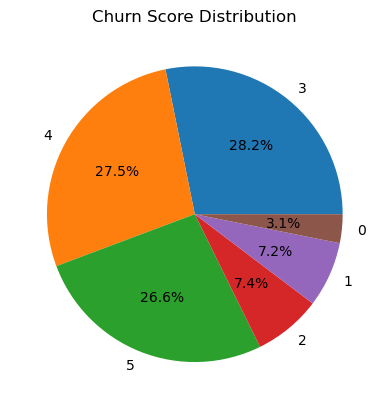

In [65]:
# Count the churn_score values
churn_score_counts = Data_eda['churn_score'].value_counts()

# Create a pie plot
plt.pie(churn_score_counts.values, labels=churn_score_counts.index, autopct='%1.1f%%')
plt.title('Churn Score Distribution')
plt.show()

Berdasarkan distribusi churn_score diatas, kita dapat mengetahui bahwa lebih banyak pelanggan yang memiliki kemungkinan churn tinggi dibandingkan yang memiliki kemungkinan churn rendah, oleh karena itu kita akan melakukan analisi kepada beberapa data dan keterhubungannya dengan churn_score.

## 4.2 Melihat keterhubungan antara membership_category dan churn_score

Pertama-tama kita harus melihat persebaran data berdasarkan kategori membership.

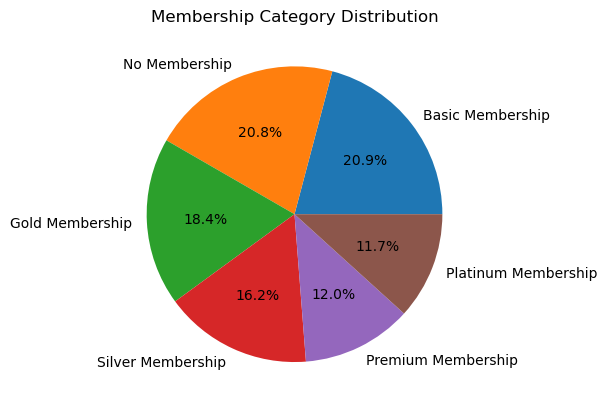

In [66]:
pas_comp = Data_eda['membership_category'].value_counts()
plt.pie(pas_comp, labels=pas_comp.index, autopct='%1.1f%%')
plt.title('Membership Category Distribution')
plt.show()

Dari diagram diatas, kita dapat mengetahui bahwa paling banyak konsumen memiliki membership basic, lalu diikuti oleh tidak memiliki membership, gold membership dan selanjutnya.

Membandingkan membership_category dengan churn_score

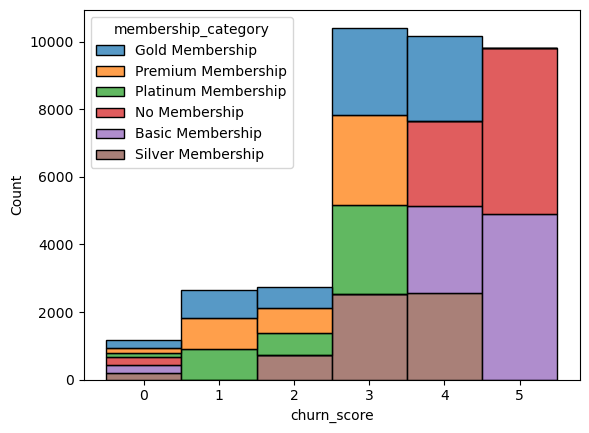

In [67]:
# f, ax = plt.subplots(figsize=(7, 5))
f = plt.figure()
sns.despine(f)
sns.histplot(Data_eda,x="churn_score",hue="membership_category", multiple='stack')
plt.show()

Dari diagram diatas,kita dapat melihat data yang memiliki kemungkinan churn tingg yaitu pada churn_score 3 hingga 5 memiliki membership yang bervariasi. namun untuk yang memiliki chrun_scorre tertinggi hanya berasal dari 2 kategori yaitu No membership dan basic membership. hal tersebut bisa terjadi karena no membership dan basic membership pastinya tidak memiliki pelayanan yang sebalik membership diatasnya. Namun disebabkan  No membership dan basic membership memiliki presentase yang tinggi di persebaran membership, maka harus ada tindakan khusus untuk mengatasi churn_score tinggi tersebut.

## 4.3 Melihat hubungan antara churn_score dengan avg_transaction_value

<Axes: xlabel='churn_score', ylabel='avg_transaction_value'>

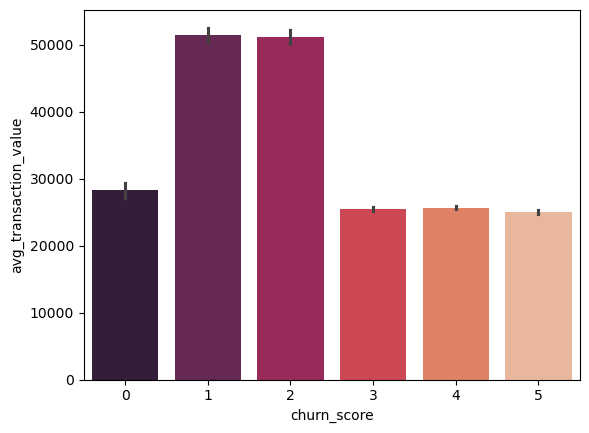

In [68]:
f = plt.figure()

x = Data_eda['avg_transaction_value']
y1 = Data_eda['churn_score']
sns.barplot(x=y1, y=x, hue=y1, palette="rocket")

Berdasarkan diagram diatas terlihat ada pola yang mana, orang yang memiliki avg_transaction_value yang rendah cenderung memiliki churn_score yang tinggi.

## 4.4 Melihat hubungan antara past_complaint dengan churn_score

Pertama-tama kita lihat dahulu persebaran pada data past_complaint

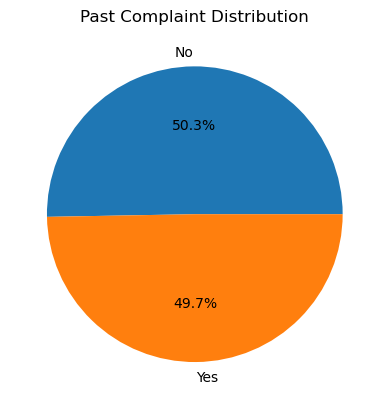

In [69]:
# membuat diagram pie untuk melihat presentase yang komplaint
pas_comp = Data_eda['past_complaint'].value_counts()
plt.pie( x=pas_comp, labels=pas_comp.index, autopct='%1.1f%%')
plt.title('Past Complaint Distribution')
plt.show()


Berdasarkan data diatas dapat dilihat bahwa persebaran orang yang pernah complaint dan belum pernah complaint memiliki persebaran yang hampir seimbang.

membandingkan past_complaint dengan churn_score

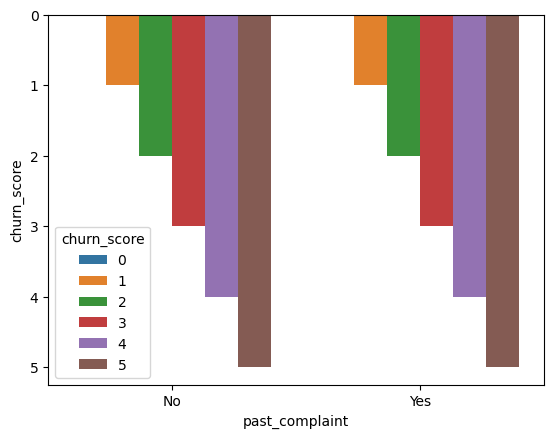

In [70]:
sns.barplot(x='past_complaint', y='churn_score',hue='churn_score', data=Data_eda)
plt.show()

Berdasarkan diagram diatas, kita dapat melihat bahwa past_complaint atau riwayat complain tidak memiliki hubungan dengan churn_score, jadi terdapat orang yang tidak pernah melakukan complain namun tetap memiliki churn_score yang tinggi.

## 4.5 Hubungan antara preferred_offer_types dengan churn_score

Melihat persebaran data preferred_offer_types

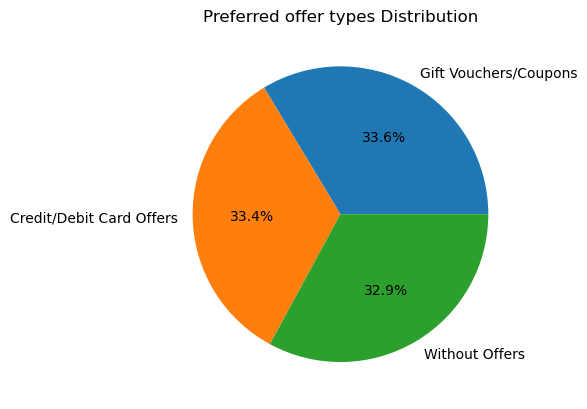

In [71]:
# membuat diagram pie untuk melihat persebaran data preferred_offer_types
pas_comp = Data_eda['preferred_offer_types'].value_counts()
plt.pie( x=pas_comp, labels=pas_comp.index, autopct='%1.1f%%')
plt.title('Preferred offer types Distribution')
plt.show()

Berdasarkan diagram diatas preferred_offer_types tiap pelanggan hampir sama antar offer satu dengan yang lain.

C:\Users\muham\AppData\Local\Temp\ipykernel_23716\40568830.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(Data_eda,x='churn_score',col='preferred_offer_types',palette="rocket")


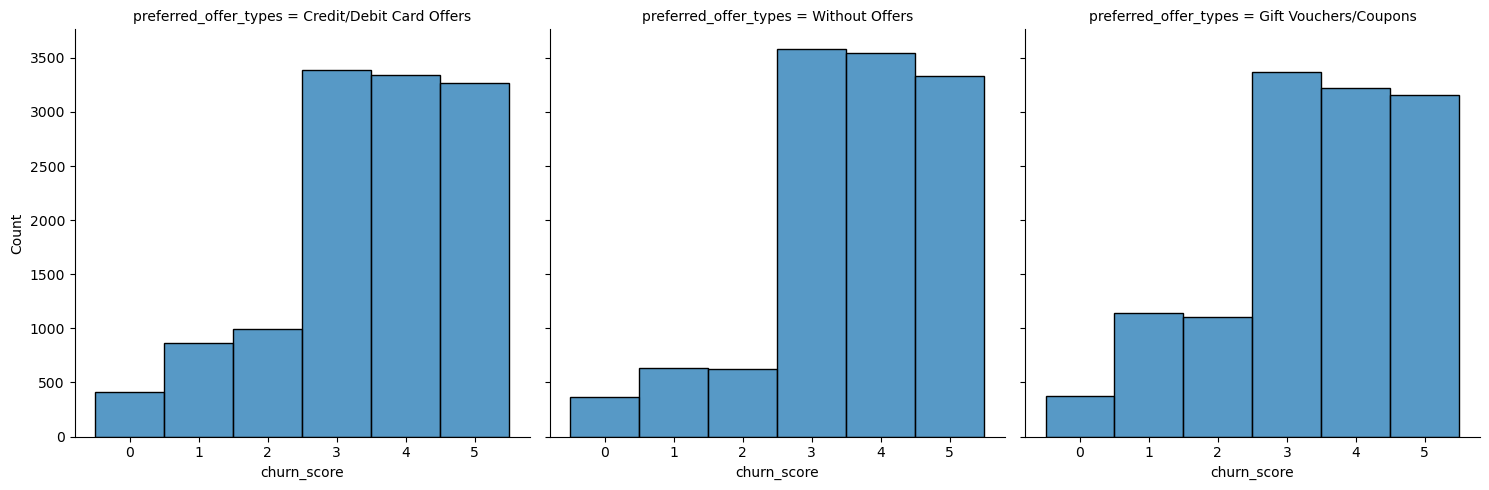

In [72]:
# melihat data preferred_offer_types dibandingkan dengan churn_score

sns.displot(Data_eda,x='churn_score',col='preferred_offer_types',palette="rocket")

Berdasarkan diagram diatas, kita dapat mengetahui bahwa tidak ada perbedaan signifikan antara preferred_offer_types.

## 4.6 melihat hubungan antara avg_time_spent dengan churn_score

<Axes: xlabel='avg_time_spent', ylabel='churn_score'>

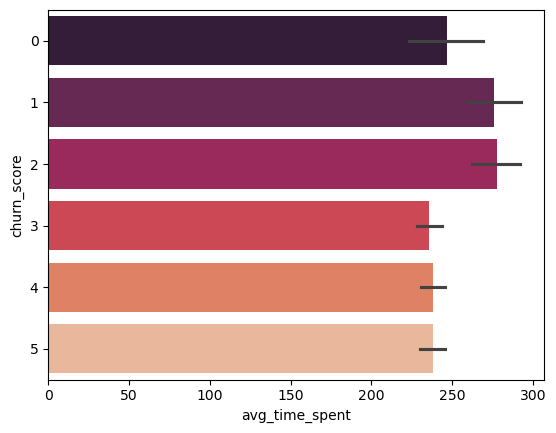

In [73]:
f = plt.figure()
x = Data_eda['avg_time_spent']
y = Data_eda['churn_score']
sns.barplot(x=x, y=y, hue=y, palette="rocket")

Berdasarkan diagram diatas, kita dapat meilhat bahwa terdapat pola bahwa pelanggan yang memiliki churn_score rendah cenderung memiliki avg_time_spent yang lebih tinggi dibandingkan orang yang memiliki churn_score tinggi.

## 4.7 Melakukan data analisis, feedback apa yang paling sering diberikan oleh pelanggan.

Dengan dilakukan analisis ini, diharapkan kita dapat mengetahui alasan pelanggan churn, dan dapat memperbaiki pada sektor tersebut.

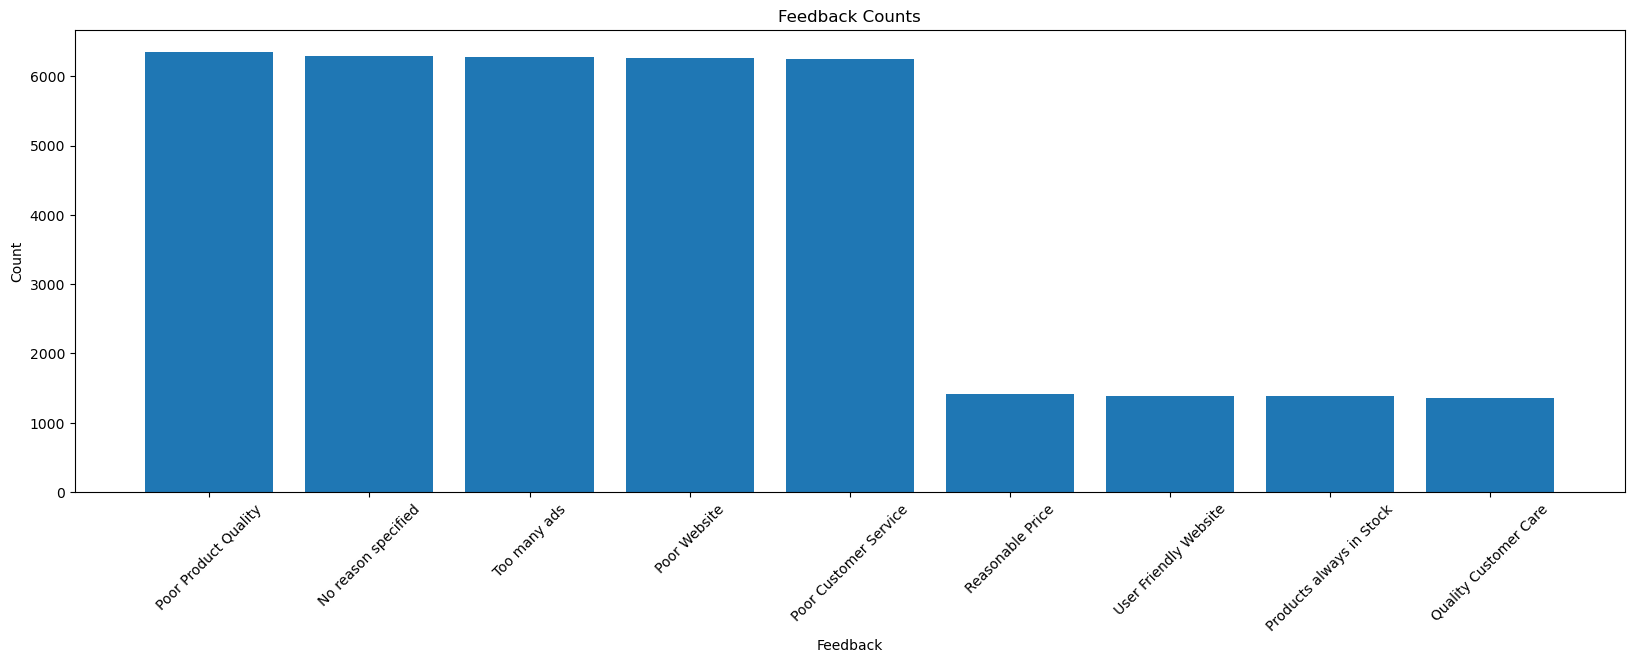

In [74]:
plt.figure(figsize=(20,6))

feedback_counts = Data_eda['feedback'].value_counts()

plt.bar(feedback_counts.index, feedback_counts.values)
plt.xlabel('Feedback')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Feedback Counts')
plt.show()

Berdasarkan feedback dari pelanggan, paling banyak pelanggan churn karena kualitas produk, terlalu banyak iklan di website, website yang kurang baik dan pelayanan customer service yang kurang memadai.

# 5.Feature Engineering

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36988 entries, 0 to 36987
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36988 non-null  object 
 1   Name                          36988 non-null  object 
 2   age                           36988 non-null  int64  
 3   gender                        36988 non-null  object 
 4   security_no                   36988 non-null  object 
 5   region_category               31562 non-null  object 
 6   membership_category           36988 non-null  object 
 7   joining_date                  36988 non-null  object 
 8   joined_through_referral       36988 non-null  object 
 9   referral_id                   36988 non-null  object 
 10  preferred_offer_types         36700 non-null  object 
 11  medium_of_operation           36988 non-null  object 
 12  internet_option               36988 non-null  object 
 13  l

Data yang akan digunakan untuk model hanyalah data-data numerical dan categorical, yang mana :

daftar data numerical :
1. age (continue)
2. days_since_last_login (continue)
3. avg_time_spent (continue) 
4. avg_frequency_login_days (continue) mv 
5. avg_transaction_value (continue)
6. points_in_wallet (continue) mv
7. churn_score (dicrete)
8. joining_date (categorical) 
9. last_visi_time (continue)

daftar data categorical :
1. gender (Nominal)
2. region_category (Nominal) mv
3. membership_category (Ordinal) 
4. Joined_through_referral (Nominal) mv
5. preferred_offer_types (nominal) mv
6. Medium_of_operation (nominal) mv
7. internet_option (nominal) 
8. used_special_disccount (nominal)
9. offer_application_preference (nominal) 
10. past_complaint (potential) (nominal)
11. complaint_status (nominal)
12. feedback (nominal)
13. sentiment (nominal)

Catatan:
1. pada data tersebut sudah saya berikan tanda terhadap data yang memiliki missing value dengan (mv).
2. pada data tersebut sudah saya tentukan jenis datanya ordinal, nominal, continue, ataupun diskrit.
catatan tersebut merupakan salah satu insight yang saya dapatkan saat data overview.

In [76]:
# Data Unique
data_unique = ['customer_id', 'Name', 'security_no', 'referral_id', 'content', 'summary']

# Data Numerical
data_numerical = ['age', 'days_since_last_login', 'avg_time_spent', 'avg_frequency_login_days', 'avg_transaction_value', 'points_in_wallet', 'churn_score','joining_date','last_visit_time']

# Data Categorical
data_categorical = ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'sentiment']



# Printing the lists
print("Data Unique:", data_unique)
print("Data Numerical:", data_numerical)
print("Data Categorical:", data_categorical)

Data Unique: ['customer_id', 'Name', 'security_no', 'referral_id', 'content', 'summary']
Data Numerical: ['age', 'days_since_last_login', 'avg_time_spent', 'avg_frequency_login_days', 'avg_transaction_value', 'points_in_wallet', 'churn_score', 'joining_date', 'last_visit_time']
Data Categorical: ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'sentiment']


Memisahkan data yang akan digunakan pada model yang mana data bertipe unique tidak digunakan pada model karena data bertipe unique pasti memiliki kardinalitas yang tinggi namun tidak berpengaruh pada hasil churn_score.

In [77]:
X = data[data_numerical + data_categorical].drop(columns='churn_score')
y = data['churn_score']

In [78]:
X

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
0,44,14,516.16,22.0,21027.00,500.690000,2016-11-11,22:53:21,F,Town,...,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,Yes,Solved in Follow-up,Poor Website,0
1,37,11,53.27,6.0,25239.56,567.660000,2016-10-29,15:57:50,M,City,...,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,Yes,Unsolved,Poor Website,0
2,31,20,113.13,16.0,24483.66,663.060000,2017-09-12,15:46:44,F,City,...,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,No,Yes,Yes,Solved,Poor Website,0
3,42,19,429.11,24.0,44554.82,568.080000,2016-07-12,07:52:43,M,NaN,...,?,Credit/Debit Card Offers,Both,Fiber_Optic,No,Yes,Yes,Unsolved,Poor Product Quality,0
4,25,14,570.23,8.0,35119.93,699.700000,2016-05-22,05:57:20,F,Village,...,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,Yes,Yes,No,Not Applicable,Poor Product Quality,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36983,42,16,34.10,Error,39439.10,1224.393346,2015-02-04,13:08:11,F,Town,...,?,Credit/Debit Card Offers,Desktop,Fiber_Optic,Yes,No,Yes,Solved in Follow-up,Too many ads,1
36984,34,18,33.68,13.0,5194.23,1011.270354,2016-02-16,19:08:32,M,City,...,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,No,Yes,Yes,Solved in Follow-up,Poor Website,1
36985,45,10,34.93,19.0,41558.93,703.030000,2016-08-31,08:30:41,F,NaN,...,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,No,No,Not Applicable,Poor Product Quality,1
36986,27,13,135.83,16.0,8225.68,748.570000,2015-09-07,05:29:19,M,Town,...,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,Yes,No,No,Not Applicable,No reason specified,1


In [79]:
y

0        5
1        5
2        5
3        5
4        5
        ..
36983    3
36984    3
36985    3
36986    3
36987    3
Name: churn_score, Length: 36988, dtype: object

## 5.1 Split data train and data test

Memisahkan antara data test dan data train.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

Train data shape: (29590, 21)
Test data shape: (7398, 21)


mengubah tipe data y_train dan y_test menjadi integerd dari object

In [81]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## 5.2 Handling Missing Value

Berdasarkan yang sudah didapatkan dari data overview, terdapat missing value pada :
1. avg_frequency_login_days - 'Error'
2. points_in_wallet - 'NaN'
3. region_category - 'NaN'
4. joined_through_referral - '?'
5. preferred_offer_types - 'NaN'
6. medium_of_operation - '?'

### 5.2.1 Handling missing value X_train

#### 5.2.1.1 Avg_frequency_login_days

In [82]:
X_train.loc[X_train['avg_frequency_login_days']=='Error']

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
36109,34,18,185.630000,Error,41100.11,172.561590,2015-10-17,20:38:46,F,Town,...,?,Credit/Debit Card Offers,Desktop,Mobile_Data,Yes,No,Yes,Unsolved,Poor Website,1
16170,19,11,235.900000,Error,97436.44,766.920000,2015-11-08,03:09:27,F,City,...,Yes,Without Offers,Desktop,Mobile_Data,Yes,Yes,Yes,Solved,Reasonable Price,1
16579,37,19,-693.904467,Error,79703.95,803.310000,2017-03-09,21:17:43,F,City,...,?,Gift Vouchers/Coupons,Smartphone,Wi-Fi,No,Yes,No,Not Applicable,User Friendly Website,1
31138,17,14,90.270000,Error,20849.22,603.310000,2015-09-04,21:21:55,M,Village,...,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,Yes,Unsolved,Poor Product Quality,1
20274,44,16,205.770000,Error,36589.09,559.460000,2015-02-16,10:55:23,F,NaN,...,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,Yes,Yes,Yes,Solved,Poor Product Quality,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,54,18,34.230000,Error,39642.95,NaN,2015-11-16,09:49:03,F,Town,...,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,No,Not Applicable,Poor Website,1
2612,11,13,201.850000,Error,1638.21,1215.000661,2017-06-03,23:18:43,F,City,...,?,Credit/Debit Card Offers,Smartphone,Wi-Fi,No,Yes,Yes,Unsolved,Too many ads,0
3556,54,-999,330.750000,Error,5151.33,NaN,2017-11-08,14:54:24,F,City,...,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,No,Yes,Unsolved,Too many ads,0
1899,21,15,788.150000,Error,9223.19,830.429252,2017-08-20,07:57:05,F,NaN,...,Yes,Without Offers,Smartphone,Fiber_Optic,No,Yes,Yes,Unsolved,Poor Product Quality,0


Mencari data rata-rata tanpa data error

In [83]:
# mengganti data error menjadi 0
X_train['avg_frequency_login_days'] = X_train['avg_frequency_login_days'].replace('Error',0)
# mengubah tipe data
X_train['avg_frequency_login_days'] = X_train['avg_frequency_login_days'].astype(float)


pembagian jumlah data dikurangi dengan jumlah data error yang telah dimasukan 0.

In [84]:
# mencari rata-rata tanpa data 0 yang dimasukan
rata_avg_login_days = X_train['avg_frequency_login_days'].sum() / (len(X_train)-2791)
rata_avg_login_days

15.97411187567092

In [85]:
X_train.loc[X_train['avg_frequency_login_days']==0]

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
36109,34,18,185.630000,0.0,41100.11,172.561590,2015-10-17,20:38:46,F,Town,...,?,Credit/Debit Card Offers,Desktop,Mobile_Data,Yes,No,Yes,Unsolved,Poor Website,1
16170,19,11,235.900000,0.0,97436.44,766.920000,2015-11-08,03:09:27,F,City,...,Yes,Without Offers,Desktop,Mobile_Data,Yes,Yes,Yes,Solved,Reasonable Price,1
16579,37,19,-693.904467,0.0,79703.95,803.310000,2017-03-09,21:17:43,F,City,...,?,Gift Vouchers/Coupons,Smartphone,Wi-Fi,No,Yes,No,Not Applicable,User Friendly Website,1
31138,17,14,90.270000,0.0,20849.22,603.310000,2015-09-04,21:21:55,M,Village,...,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,Yes,Unsolved,Poor Product Quality,1
20274,44,16,205.770000,0.0,36589.09,559.460000,2015-02-16,10:55:23,F,NaN,...,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,Yes,Yes,Yes,Solved,Poor Product Quality,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,54,18,34.230000,0.0,39642.95,NaN,2015-11-16,09:49:03,F,Town,...,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,No,Not Applicable,Poor Website,1
2612,11,13,201.850000,0.0,1638.21,1215.000661,2017-06-03,23:18:43,F,City,...,?,Credit/Debit Card Offers,Smartphone,Wi-Fi,No,Yes,Yes,Unsolved,Too many ads,0
3556,54,-999,330.750000,0.0,5151.33,NaN,2017-11-08,14:54:24,F,City,...,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,No,Yes,Unsolved,Too many ads,0
1899,21,15,788.150000,0.0,9223.19,830.429252,2017-08-20,07:57:05,F,NaN,...,Yes,Without Offers,Smartphone,Fiber_Optic,No,Yes,Yes,Unsolved,Poor Product Quality,0


karena ternyata jumlah 0 sama dengan jumlah yang sebelumnya diinputkan, maka bisa ditarik kesimpulan bahwa jumlah 0 sama dengan jumlah error yang awal. kita akan melakukan penggantian 0 dengan menggunakan rata-rata data.

In [86]:
# mengganti data error menjadi 0
X_train['avg_frequency_login_days'] = X_train['avg_frequency_login_days'].replace(0,rata_avg_login_days)
# mengubah tipe data
X_train['avg_frequency_login_days'] = X_train['avg_frequency_login_days'].astype(float)

memeriksa apakah data 'Error' atau 0 masih ada.

In [87]:
X_train.loc[(X_train['avg_frequency_login_days']=='Error') | (X_train['avg_frequency_login_days']==0)]

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment


Missing value berhasil diatasi.

In [88]:
# melihat apakah data terdistribusi normal.
X_train['avg_frequency_login_days'].skew()

-0.013967349484529348

data terdistribusi normal

#### 5.2.1.2 Points_in_wallet

In [89]:
X_train.loc[X_train['points_in_wallet'].isna()]

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
34456,56,13,-756.107563,26.000000,35039.98,NaN,2015-04-16,16:18:18,F,Town,...,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,Yes,No,No,Not Applicable,No reason specified,1
13694,19,12,201.020000,11.000000,32479.35,NaN,2015-10-19,12:32:09,F,Village,...,No,Without Offers,Smartphone,Fiber_Optic,Yes,No,No,Not Applicable,Quality Customer Care,1
1053,48,9,371.470000,5.000000,27061.15,NaN,2015-08-22,04:52:40,M,City,...,Yes,Without Offers,Smartphone,Mobile_Data,No,Yes,No,Not Applicable,Poor Customer Service,0
27533,11,18,97.430000,15.974112,3421.86,NaN,2016-04-10,05:18:23,F,City,...,No,Without Offers,Desktop,Wi-Fi,No,Yes,Yes,Solved,No reason specified,1
9285,57,3,486.550000,5.000000,30951.27,NaN,2017-10-06,11:14:53,M,Town,...,No,Credit/Debit Card Offers,Desktop,Mobile_Data,No,Yes,Yes,No Information Available,Too many ads,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,54,-999,330.750000,15.974112,5151.33,NaN,2017-11-08,14:54:24,F,City,...,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,No,Yes,Unsolved,Too many ads,0
18431,57,11,134.340000,11.000000,70584.40,NaN,2016-11-24,18:42:30,M,City,...,No,Without Offers,Desktop,Fiber_Optic,Yes,No,No,Not Applicable,Reasonable Price,1
25658,25,11,479.590000,14.000000,42008.06,NaN,2015-03-26,19:02:48,F,Town,...,No,Credit/Debit Card Offers,Smartphone,Wi-Fi,No,Yes,No,Not Applicable,Poor Product Quality,1
28693,26,8,88.250000,7.000000,40811.02,NaN,2015-01-18,17:32:50,M,Town,...,?,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,No,Not Applicable,Poor Website,1


In [90]:
X_train['points_in_wallet'].skew()

-0.07774772649259565

karena data terdistribusi normal, maka saya akan memasukan data mean()

In [91]:
X_train['points_in_wallet'] = X_train['points_in_wallet'].fillna(X_train['points_in_wallet'].mean())

memeriksa apakah masih ada missing value

In [92]:
X_train['points_in_wallet'].isna().sum()

0

#### 5.2.1.3 region_category

In [93]:
X_train.loc[X_train['region_category'].isna()]

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
31264,52,-999,33.090000,17.000000,39033.78,620.060000,2015-09-16,00:30:16,F,NaN,...,Yes,Credit/Debit Card Offers,Desktop,Fiber_Optic,Yes,No,Yes,No Information Available,Poor Website,1
6341,28,2,153.580000,16.000000,48211.70,651.530000,2015-09-02,11:35:16,F,NaN,...,Yes,Without Offers,Smartphone,Fiber_Optic,No,Yes,No,Not Applicable,Poor Product Quality,0
9154,38,3,1054.220000,19.000000,48451.57,719.650000,2015-11-23,10:14:30,M,NaN,...,Yes,Credit/Debit Card Offers,Desktop,Fiber_Optic,Yes,No,No,Not Applicable,Poor Product Quality,1
12024,47,9,527.470000,8.000000,34913.69,736.680000,2015-11-12,20:00:56,M,NaN,...,Yes,Without Offers,Smartphone,Mobile_Data,No,Yes,Yes,Solved,Poor Product Quality,1
34625,30,13,1005.742827,21.000000,40074.82,702.140000,2017-09-09,17:20:42,F,NaN,...,Yes,Credit/Debit Card Offers,Desktop,Fiber_Optic,No,Yes,No,Not Applicable,Poor Customer Service,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23483,22,20,127.000000,20.000000,26324.34,535.320000,2015-05-26,05:27:00,F,NaN,...,No,Credit/Debit Card Offers,?,Fiber_Optic,No,Yes,Yes,No Information Available,Poor Website,1
10627,28,23,30.590000,23.000000,43277.61,757.070000,2017-07-31,16:22:40,F,NaN,...,No,Credit/Debit Card Offers,Desktop,Wi-Fi,No,Yes,No,Not Applicable,Too many ads,1
1899,21,15,788.150000,15.974112,9223.19,830.429252,2017-08-20,07:57:05,F,NaN,...,Yes,Without Offers,Smartphone,Fiber_Optic,No,Yes,Yes,Unsolved,Poor Product Quality,0
35773,15,14,474.310000,6.000000,20765.00,444.113192,2016-04-09,02:37:50,M,NaN,...,Yes,Without Offers,?,Fiber_Optic,Yes,Yes,No,Not Applicable,Too many ads,1


Coba melihat apakah ada keterhubungan antara region_category dengan beberapa data yang kemungkinan terhubung seperti medium_of_operation dan internet_options.

In [94]:
X_train[['region_category','medium_of_operation', 'internet_option']]

,region_category,medium_of_operation,internet_option
8856,City,Desktop,Mobile_Data
31264,NaN,Desktop,Fiber_Optic
33733,Village,?,Fiber_Optic
36109,Town,Desktop,Mobile_Data
16170,City,Desktop,Mobile_Data
...,...,...,...
16850,Village,Both,Mobile_Data
6265,City,Smartphone,Fiber_Optic
11284,Village,Desktop,Mobile_Data
860,Village,Smartphone,Wi-Fi


Karena tidak ada keterhubungan, maka kita hanya bisa mengisikan dengan modus dari data tersebut.

In [95]:
X_train['region_category'] = X_train['region_category'].fillna(X_train['region_category'].mode)
X_train['region_category'].isna().sum()

0

In [96]:
X_train['region_category'].isna().sum()

0

#### 5.2.1.4 joined_through_referral 

In [97]:
X_train.loc[X_train['joined_through_referral']=='?']

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
8856,40,10,141.620000,14.000000,23297.14,705.560000,2016-10-04,04:20:13,M,City,...,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,No,Not Applicable,Poor Website,1
36109,34,18,185.630000,15.974112,41100.11,172.561590,2015-10-17,20:38:46,F,Town,...,?,Credit/Debit Card Offers,Desktop,Mobile_Data,Yes,No,Yes,Unsolved,Poor Website,1
16579,37,19,-693.904467,15.974112,79703.95,803.310000,2017-03-09,21:17:43,F,City,...,?,Gift Vouchers/Coupons,Smartphone,Wi-Fi,No,Yes,No,Not Applicable,User Friendly Website,1
33390,45,7,210.200000,24.000000,11132.38,372.607542,2016-09-14,22:03:56,F,Town,...,?,Credit/Debit Card Offers,Desktop,Mobile_Data,No,Yes,No,Not Applicable,Poor Product Quality,1
17122,45,20,38.680000,3.000000,38584.55,806.810000,2015-04-01,23:39:19,M,City,...,?,Without Offers,Smartphone,Mobile_Data,Yes,No,Yes,No Information Available,Quality Customer Care,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18942,53,2,1408.104085,12.000000,60921.98,785.570000,2017-05-03,18:10:00,M,Town,...,?,Credit/Debit Card Offers,Desktop,Mobile_Data,Yes,No,Yes,Solved in Follow-up,Quality Customer Care,1
6396,39,-999,791.930000,21.000000,44462.37,701.050000,2017-06-22,03:41:34,M,Town,...,?,Without Offers,Both,Wi-Fi,Yes,No,Yes,Unsolved,Too many ads,0
28693,26,8,88.250000,7.000000,40811.02,687.079015,2015-01-18,17:32:50,M,Town,...,?,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,No,Not Applicable,Poor Website,1
21962,24,12,-798.547229,22.000000,36630.17,687.079015,2017-07-16,22:53:43,F,Town,...,?,Without Offers,Desktop,Fiber_Optic,No,Yes,Yes,Unsolved,Poor Website,1


lihat apakah data normal.

In [98]:
X_train['joined_through_referral'].value_counts().skew()

-1.7320504666713004

data sangat skew, oleh karena itu kita inputkan dengan modus dari data

In [99]:
X_train['joined_through_referral'] = X_train['joined_through_referral'].astype(str)

In [100]:
X_train['joined_through_referral'] = X_train['joined_through_referral'].replace('?', np.nan)
X_train['joined_through_referral'] = X_train['joined_through_referral'].fillna(X_train['joined_through_referral'].mode()[0])

memeriksa apakah masih ada missing value.

In [101]:
X_train.loc[X_train['joined_through_referral']=='?']

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment


#### 5.2.1.5 preffered_offer_types

In [102]:
X_train.loc[X_train['preferred_offer_types'].isna()]

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
25569,50,15,135.98,39.556962,13816.91,630.950000,2017-11-08,07:53:54,F,Village,...,No,NaN,Smartphone,Wi-Fi,Yes,No,Yes,Solved in Follow-up,Too many ads,1
27287,34,18,374.36,26.000000,26614.35,662.760000,2015-04-27,23:45:25,F,City,...,Yes,NaN,?,Fiber_Optic,Yes,Yes,No,Not Applicable,Poor Website,1
12440,30,20,243.42,6.000000,30128.85,737.440000,2016-08-23,20:26:27,F,Town,...,Yes,NaN,Both,Mobile_Data,Yes,Yes,Yes,Unsolved,No reason specified,1
36668,62,13,214.16,19.000000,29162.34,203.986178,2016-05-16,15:00:05,F,City,...,No,NaN,?,Fiber_Optic,No,Yes,No,Not Applicable,Poor Customer Service,1
7220,41,16,328.22,15.974112,18493.49,648.380000,2015-04-25,02:06:40,F,Town,...,Yes,NaN,Desktop,Mobile_Data,No,Yes,No,Not Applicable,Poor Website,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,21,7,57.41,27.000000,35040.46,678.230000,2017-03-28,06:25:22,M,Town,...,Yes,NaN,Smartphone,Mobile_Data,No,Yes,Yes,No Information Available,No reason specified,1
27472,18,12,263.12,17.000000,21491.71,1085.815633,2017-03-19,08:31:06,F,City,...,Yes,NaN,Desktop,Mobile_Data,No,Yes,Yes,No Information Available,Poor Product Quality,1
10647,38,-999,32.85,5.000000,15076.83,740.030000,2017-09-29,10:39:26,F,Town,...,Yes,NaN,Desktop,Wi-Fi,Yes,No,No,Not Applicable,Poor Customer Service,1
33986,29,14,196.24,25.000000,27934.31,799.460000,2016-10-13,08:57:13,M,City,...,No,NaN,Desktop,Wi-Fi,No,Yes,Yes,Solved,No reason specified,1


memasukan input modus terhadap data.

In [103]:
mode_pot = X_train['preferred_offer_types'].mode()[0]
X_train['preferred_offer_types'] = X_train['preferred_offer_types'].fillna(mode_pot)

memeriksa apakah masih ada missing value.

In [104]:
X_train.isna().sum()

age                             0
days_since_last_login           0
avg_time_spent                  0
avg_frequency_login_days        0
avg_transaction_value           0
points_in_wallet                0
joining_date                    0
last_visit_time                 0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
sentiment                       0
dtype: int64

#### 5.2.1.6 medium_of_operation

In [105]:
X_train.loc[X_train['medium_of_operation']=='?']

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment
33733,39,24,30.85,13.000000,43539.32,791.187516,2016-02-27,15:12:37,F,Village,...,Yes,Without Offers,?,Fiber_Optic,No,Yes,No,Not Applicable,Poor Product Quality,1
677,13,4,315.25,10.000000,40613.31,594.710000,2015-02-24,19:11:58,M,Town,...,No,Credit/Debit Card Offers,?,Fiber_Optic,No,Yes,No,Not Applicable,Poor Website,0
5414,11,23,176.31,25.000000,8983.02,707.460000,2016-06-22,01:42:15,M,City,...,No,Credit/Debit Card Offers,?,Wi-Fi,No,Yes,Yes,Solved,Poor Product Quality,0
17873,59,22,38.78,4.000000,65764.66,1114.304579,2016-08-14,15:09:44,M,Town,...,No,Without Offers,?,Mobile_Data,No,Yes,Yes,No Information Available,User Friendly Website,1
21688,64,-999,45.59,8.000000,18682.82,995.164971,2015-07-20,02:58:46,F,City,...,Yes,Credit/Debit Card Offers,?,Wi-Fi,No,Yes,No,Not Applicable,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,54,-999,330.75,15.974112,5151.33,687.079015,2017-11-08,14:54:24,F,City,...,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,No,Yes,Unsolved,Too many ads,0
35773,15,14,474.31,6.000000,20765.00,444.113192,2016-04-09,02:37:50,M,<bound method Series.mode of 8856 City\...,...,Yes,Without Offers,?,Fiber_Optic,Yes,Yes,No,Not Applicable,Too many ads,1
27480,45,8,616.58,8.000000,46863.44,372.538742,2016-06-21,10:44:45,M,Town,...,Yes,Without Offers,?,Mobile_Data,Yes,No,No,Not Applicable,Poor Customer Service,1
5311,45,8,173.59,15.974112,37318.96,882.270330,2016-10-20,12:56:29,M,Town,...,No,Without Offers,?,Fiber_Optic,No,Yes,Yes,Solved in Follow-up,Too many ads,0


Medium_of_operation apakan input modus terhadap data.

In [106]:
X_train['medium_of_operation'] = X_train['medium_of_operation'].replace('?', np.nan)
X_train['medium_of_operation'] = X_train['medium_of_operation'].fillna(X_train['joined_through_referral'].mode()[0])

In [107]:
# melakukan pemeriksaan terhadap missing value di medium_of_operation
X_train.isna().sum()

age                             0
days_since_last_login           0
avg_time_spent                  0
avg_frequency_login_days        0
avg_transaction_value           0
points_in_wallet                0
joining_date                    0
last_visit_time                 0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
sentiment                       0
dtype: int64

### 5.2.2 Hanlding missing value pada X_test

In [108]:
# melakukan handling missing value pada X_test seperti yang dilakukan pada X_train

# Avg_frequency_login_days
X_test['avg_frequency_login_days'] = X_test['avg_frequency_login_days'].replace('Error',0)
X_test['avg_frequency_login_days'] = X_test['avg_frequency_login_days'].astype(float)

# Points_in_wallet
X_test['points_in_wallet'] = X_test['points_in_wallet'].fillna(X_train['points_in_wallet'].mean())

# region_category
X_test['region_category'] = X_test['region_category'].fillna(X_train['region_category'].mode)

# joined_through_referral
X_test['joined_through_referral'] = X_test['joined_through_referral'].astype(str)
X_test['joined_through_referral'] = X_test['joined_through_referral'].replace('?', np.nan)
X_test['joined_through_referral'] = X_test['joined_through_referral'].fillna(X_train['joined_through_referral'].mode()[0])

# preferred_offer_types
X_test['preferred_offer_types'] = X_test['preferred_offer_types'].fillna(X_train['preferred_offer_types'].mode()[0])

# medium_of_operation
X_test['medium_of_operation'] = X_test['medium_of_operation'].replace('?', np.nan)
X_test['medium_of_operation'] = X_test['medium_of_operation'].fillna(X_train['joined_through_referral'].mode()[0])

In [109]:
X_test.isna().sum()

age                             0
days_since_last_login           0
avg_time_spent                  0
avg_frequency_login_days        0
avg_transaction_value           0
points_in_wallet                0
joining_date                    0
last_visit_time                 0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
sentiment                       0
dtype: int64

## 5.3 Feature Selection

melihat tipe data X_train.

In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29590 entries, 8856 to 15795
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           29590 non-null  int64  
 1   days_since_last_login         29590 non-null  int64  
 2   avg_time_spent                29590 non-null  float64
 3   avg_frequency_login_days      29590 non-null  float64
 4   avg_transaction_value         29590 non-null  float64
 5   points_in_wallet              29590 non-null  float64
 6   joining_date                  29590 non-null  object 
 7   last_visit_time               29590 non-null  object 
 8   gender                        29590 non-null  object 
 9   region_category               29590 non-null  object 
 10  membership_category           29590 non-null  object 
 11  joined_through_referral       29590 non-null  object 
 12  preferred_offer_types         29590 non-null  object 
 13  med

Menggunakan phik untuk mengetahui seberapa besar korelasi antar data.

In [111]:
phik_overview = pd.concat([X_train,y_train], axis=1).phik_matrix()
phik_overview


interval columns not set, guessing: ['age', 'days_since_last_login', 'avg_time_spent', 'avg_frequency_login_days', 'avg_transaction_value', 'points_in_wallet', 'sentiment', 'churn_score']


c:\Users\muham\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable joining_date is large: 1096. Are you sure this is not an interval variable? Analysis for pairs of variables including joining_date can be slow.
  warnings.warn(
c:\Users\muham\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable last_visit_time is large: 25003. Are you sure this is not an interval variable? Analysis for pairs of variables including last_visit_time can be slow.
  warnings.warn(


,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment,churn_score
age,1.000000,0.000000,0.000000,0.000000,0.027217,0.000000,0.000000,0.154235,0.000000,0.009247,...,0.007848,0.000000,0.030480,0.000000,0.000000,0.014028,0.000000,0.013308,0.010422,0.000000
days_since_last_login,0.000000,1.000000,0.000000,0.012905,0.016287,0.008181,0.000000,0.000000,0.004278,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005926,0.012613,0.000000,0.021257
avg_time_spent,0.000000,0.000000,1.000000,0.031550,0.041220,0.021896,0.087563,0.550598,0.000000,0.014323,...,0.021468,0.340080,0.016322,0.144204,0.138766,0.003673,0.010939,0.048809,0.010672,0.055895
avg_frequency_login_days,0.000000,0.012905,0.031550,1.000000,0.242503,0.073734,0.068918,0.000000,0.000000,0.013473,...,0.029764,0.010776,0.000000,0.000000,0.000000,0.023271,0.018083,0.247209,0.100207,0.267001
avg_transaction_value,0.027217,0.016287,0.041220,0.242503,1.000000,0.197750,0.000000,0.124787,0.000000,0.031509,...,0.069671,0.042218,0.014584,0.000000,0.043871,0.000000,0.000000,0.483696,0.197217,0.519471
points_in_wallet,0.000000,0.008181,0.021896,0.073734,0.197750,1.000000,0.000000,0.818654,0.000000,0.025069,...,0.040586,0.000000,0.000000,0.000000,0.029569,0.016910,0.000000,0.209057,0.163987,0.329666
joining_date,0.000000,0.000000,0.087563,0.068918,0.000000,0.000000,1.000000,0.000000,0.013485,0.000000,...,0.000000,0.051129,0.065393,0.000000,0.000000,0.050230,0.075679,0.000000,0.046822,0.059880
last_visit_time,0.154235,0.000000,0.550598,0.000000,0.124787,0.818654,0.000000,1.000000,0.455533,0.200084,...,0.000000,0.000000,0.252019,0.000000,0.091917,0.072379,0.148187,0.158520,0.221531,0.163635
gender,0.000000,0.004278,0.000000,0.000000,0.000000,0.000000,0.013485,0.455533,1.000000,0.000000,...,0.023280,0.000000,0.000000,0.000000,0.000000,0.002907,0.003307,0.000000,0.000000,0.000000
region_category,0.009247,0.000000,0.014323,0.013473,0.031509,0.025069,0.000000,0.200084,0.000000,1.000000,...,0.001989,0.023105,0.008558,0.017659,0.010024,0.010479,0.000000,0.043935,0.005046,0.042692


Saya melakukan seleksi fitur dengan menetapkan batas minimum pengaruh fitur terhadap churn_score adalah 10%, oleh karena itu fitur yang masih digunakan untuk model adalah :
1. avg_frequency_login_days
2. avg_transaction_value
3. points_in_wallet
4. last_visit_time
5. membership_category
6. preferred_offer_types
7. feedback
8. sentiment

In [112]:
features = ['avg_frequency_login_days','avg_transaction_value','points_in_wallet','last_visit_time','membership_category','preferred_offer_types','feedback','sentiment'
]

## 5.4 Check Cardinality

melihat kardinality dari data yang akan digunakan untuk model.

In [113]:
X_train[features].nunique()

avg_frequency_login_days     1336
avg_transaction_value       29529
points_in_wallet            20140
last_visit_time             25003
membership_category             6
preferred_offer_types           3
feedback                        9
sentiment                       2
dtype: int64

karena kita hanya membagi kardinalitas pada data kategori, maka saya akan mengatur kardinalitas pada last_visit_time, yang akan saya kelompokan menjadi Dini Hari, Pagi, Siang, Sore , dan Malam.

In [114]:

X_train['last_visit_time'] = pd.to_datetime(X_train['last_visit_time'])
X_train['last_visit_time'] = X_train['last_visit_time'].dt.hour
X_test['last_visit_time'] = pd.to_datetime(X_test['last_visit_time'])
X_test['last_visit_time'] = X_test['last_visit_time'].dt.hour

def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Dini Hari'
    elif 6 <= hour < 12:
        return 'Pagi'
    elif 12 <= hour < 3:
        return 'Siang'
    elif 3 <= hour < 6:
        return 'Sore'
    else:  
        return 'Malam'
    
X_train['last_visit_time'] = X_train['last_visit_time'].apply(categorize_time)
X_test['last_visit_time'] = X_test['last_visit_time'].apply(categorize_time)

X_train[features].head()

C:\Users\muham\AppData\Local\Temp\ipykernel_23716\305561014.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_train['last_visit_time'] = pd.to_datetime(X_train['last_visit_time'])
C:\Users\muham\AppData\Local\Temp\ipykernel_23716\305561014.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X_test['last_visit_time'] = pd.to_datetime(X_test['last_visit_time'])


,avg_frequency_login_days,avg_transaction_value,points_in_wallet,last_visit_time,membership_category,preferred_offer_types,feedback,sentiment
8856,14.000000,23297.14,705.560000,Dini Hari,Silver Membership,Gift Vouchers/Coupons,Poor Website,1
31264,17.000000,39033.78,620.060000,Dini Hari,Basic Membership,Credit/Debit Card Offers,Poor Website,1
33733,13.000000,43539.32,791.187516,Malam,Silver Membership,Without Offers,Poor Product Quality,1
36109,15.974112,41100.11,172.561590,Malam,Platinum Membership,Credit/Debit Card Offers,Poor Website,1
16170,15.974112,97436.44,766.920000,Dini Hari,Platinum Membership,Without Offers,Reasonable Price,1


In [115]:
# menentukan tipe data:
Numerik_kontinue = ['avg_frequency_login_days', 'avg_transaction_value', 'points_in_wallet']
Kategori_ordinal = ['membership_category']
Kategori_nominal = ['last_visit_time', 'preferred_offer_types', 'feedback','sentiment']

## 5.5 Handling Outlier

In [116]:
X_train[Numerik_kontinue].info()

<class 'pandas.core.frame.DataFrame'>
Index: 29590 entries, 8856 to 15795
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   avg_frequency_login_days  29590 non-null  float64
 1   avg_transaction_value     29590 non-null  float64
 2   points_in_wallet          29590 non-null  float64
dtypes: float64(3)
memory usage: 924.7 KB


Melihat apakah data skew atau normal.

In [117]:
data_extreme = []
data_skew = []
data_normal = []

def cek_skew(data):
    for column in Numerik_kontinue:
        if data[column].skew() >= 1 or data[column].skew() <= -1:
            data_extreme.append(column)
        elif data[column].skew() >= 0.5 or data[column].skew() <= -0.5:
            data_skew.append(column)
        else:
            data_normal.append(column)
    print('Data extreme = ', data_extreme)
    print('Data skew = ', data_skew)
    print('Data normal = ', data_normal)

cek_skew(X_train)



Data extreme =  ['avg_transaction_value']
Data skew =  []
Data normal =  ['avg_frequency_login_days', 'points_in_wallet']


Untuk data extreme skew akan digunakan akan digunakan winsorizer dengan iqr fold 3, sedangkan data normal akan menggunakan gaussian

In [118]:
normal_cap = winsorizer(capping_method='gaussian',
                        fold = 3,
                        tail = 'both',
                        variables = data_normal)
extreme_cap = winsorizer(capping_method='iqr',
                         fold=3,
                         tail = 'both',
                         variables = data_extreme)

## 5.6 Data Scaling

In [119]:
num_normal_scale = Pipeline([
    ('winsorizer', normal_cap),
    ('scaler', StandardScaler())
])

num_skew_scale = Pipeline([ 
    ('winsorizer', extreme_cap),
    ('robust', RobustScaler())
])

## 5.7 Data Encoding

In [120]:
X_train['membership_category'].unique()

array(['Silver Membership', 'Basic Membership', 'Platinum Membership',
       'No Membership', 'Gold Membership', 'Premium Membership'],
      dtype=object)

In [121]:
Nominal_encoding = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Ordered_encoding = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values with the median
    ('ordinal', OrdinalEncoder(categories=[
        ['No Membership', 'Basic Membership', 'Silver Membership', 'Gold Membership', 'Platinum Membership', 'Premium Membership']
    ]))
])

In [122]:
X_train['membership_category'].unique()

array(['Silver Membership', 'Basic Membership', 'Platinum Membership',
       'No Membership', 'Gold Membership', 'Premium Membership'],
      dtype=object)

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_nominal', Nominal_encoding, Kategori_nominal)
        ,('num_skew', num_skew_scale,data_extreme)
        ,('cat_ordinal', Ordered_encoding, Kategori_ordinal)
        ,('num_normal',num_normal_scale, data_normal)
        
    ], remainder='drop')

In [124]:
X_train.loc[X_train['medium_of_operation']=='?']

,age,days_since_last_login,avg_time_spent,avg_frequency_login_days,avg_transaction_value,points_in_wallet,joining_date,last_visit_time,gender,region_category,...,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,sentiment


Menyimpan data bersih

## 5.8 Data Balancing

Melihat persebaran data pada data target.

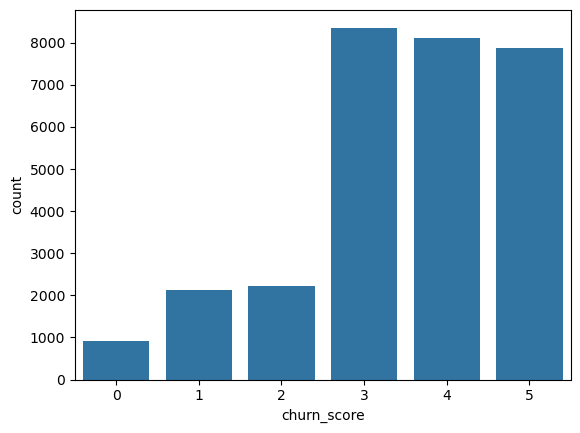

In [125]:
sns.countplot(x=y_train)
plt.show()

Data tidak seimbang, oleh karena itu ada baiknya dilakukan data balancing.

Melakukan data balancing dengan menggunakan SMOTENC karena SMOTE lebih cocok hanya untuk data numerik

In [126]:
smotenc = SMOTENC([3,4,5, 6, 7], random_state = 42)
X_train, y_train = smotenc.fit_resample(X_train[features], y_train)
y_train.value_counts()

churn_score
3    8358
4    8358
2    8358
5    8358
1    8358
0    8358
Name: count, dtype: int64

# 6. Model 

## 6.1 Search for Best Model

Mencari model terbaik dengan menggunakan cross validation dengan cara membandingkan beberapa model seperti :
1. SVC model
2. DecisionTreeClassifier model
3. RandomForestClassifier model
4. KNeighborsClassifier model
5. GaussianNB model
6. XGBClassifier model

In [127]:
# Membuat pipeline untuk setiap model yang akan dibandingkan
pipe_svc = Pipeline([('preprocessor', preprocessor), ('classifier', SVC())])
pipe_dt = Pipeline([('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(random_state=10))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=10))])
pipe_knn = Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
pipe_nb = Pipeline([('preprocessor', preprocessor),('classifier', GaussianNB())])
pipe_xgb = Pipeline([('preprocessor', preprocessor),('classifier', XGBClassifier())])

In [128]:
# Menentukan skfold 
skfold = StratifiedKFold(n_splits = 5)

In [129]:
# Membuat cross-validation untuk setiap model dan gunakan scoring akurasi
cv_svm_model = cross_val_score(pipe_svc, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)
cv_dt_model = cross_val_score(pipe_dt, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)
cv_rf_model = cross_val_score(pipe_rf, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)
cv_knn_model = cross_val_score(pipe_knn, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)
cv_nb_model = cross_val_score(pipe_nb, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)
cv_xgb_model = cross_val_score(pipe_xgb, X_train, y_train, cv = skfold, scoring='accuracy', n_jobs=-1)

In [130]:
# Mencari model dengan hasil scoring akurasi terbaik
name_model = []
cv_scores = 0
for cv,name in zip([cv_svm_model,cv_dt_model,cv_rf_model,cv_knn_model,cv_nb_model,cv_xgb_model],
                   ['svm_model','dt_model','rf_model','knn_model','nb_model','xgb_model']):
  print(name)
  print('f1score - All - Cross Validation :', cv)
  print('f1score - Mean - Cross Validation :', cv.mean())
  print('f1score - std - Cross Validation :', cv.std())
  print('f1score - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

svm_model
f1score - All - Cross Validation : [0.63748754 0.65782652 0.66909272 0.66387476 0.65888922]
f1score - Mean - Cross Validation : 0.6574341528212253
f1score - std - Cross Validation : 0.010747486562627329
f1score - Range of Test Set : 0.6466866662585979 - 0.6681816393838527
--------------------------------------------------
dt_model
f1score - All - Cross Validation : [0.68723829 0.72741775 0.74925224 0.73427062 0.73935587]
f1score - Mean - Cross Validation : 0.7275069516746401
f1score - std - Cross Validation : 0.0213568496290093
f1score - Range of Test Set : 0.7061501020456308 - 0.7488638013036494
--------------------------------------------------
rf_model
f1score - All - Cross Validation : [0.71734796 0.78713858 0.8003988  0.79988035 0.80147572]
f1score - Mean - Cross Validation : 0.7812482822745246
f1score - std - Cross Validation : 0.03237589502819637
f1score - Range of Test Set : 0.7488723872463282 - 0.813624177302721
--------------------------------------------------
knn_

Berdasarkan hasil diatas, didapatkan bahwa model terbaik untuk data yang sedang digunakan adalah XGboost Classifier, oleh karena itu untuk selanjutnya akan menggunakan XGBoost Classifier.

## 6.2 Model Definition

Apa itu XGBoost Classifier?

XGBoost (Extreme Gradient Boosting) adalah algoritma machine learning yang sangat populer, terutama untuk masalah klasifikasi dan regresi. Sederhananya, XGBoost membangun model prediktif dengan cara menggabungkan banyak model yang lebih sederhana (disebut pohon keputusan). Setiap pohon keputusan ini "belajar" dari kesalahan pohon sebelumnya, sehingga model akhir menjadi semakin akurat.

Bagaimana Cara Kerjanya?

Membuat Pohon Pertama: Algoritma mulai dengan membuat pohon keputusan sederhana. Pohon ini mencoba memisahkan data menjadi kelompok-kelompok yang homogen (misalnya, data dengan kelas yang sama).
Membuat Pohon Selanjutnya: Kemudian, pohon kedua dibuat. Namun, pohon ini tidak belajar dari seluruh data, melainkan dari sisa kesalahan yang dibuat oleh pohon pertama. Tujuannya adalah untuk memperbaiki kesalahan yang belum tertangkap oleh pohon pertama.
Mengulang Proses: Proses ini terus berulang hingga mencapai jumlah pohon yang ditentukan atau kriteria berhenti lainnya.
Menggabungkan Pohon: Semua pohon yang telah dibuat kemudian digabungkan untuk menghasilkan model prediksi akhir.
Kelebihan XGBoost:

Akurasi Tinggi: XGBoost seringkali menghasilkan model dengan akurasi yang sangat tinggi, terutama untuk data yang kompleks.
Fleksibel: Dapat menangani berbagai jenis data, baik numerik maupun kategorikal.
Efisien: Meskipun kompleks, XGBoost telah dioptimasi untuk kinerja yang cepat, bahkan untuk dataset yang sangat besar.
Regularisasi: Memiliki mekanisme regularisasi yang kuat untuk mencegah overfitting (model terlalu cocok dengan data latih sehingga performanya buruk pada data uji).
Handling Missing Values: Dapat menangani data yang hilang dengan baik.
Kekurangan XGBoost:

Kompleksitas: XGBoost adalah algoritma yang cukup kompleks, sehingga membutuhkan pemahaman yang baik untuk melakukan tuning parameter.
Waktu Training: Untuk dataset yang sangat besar, proses training bisa memakan waktu yang cukup lama.
Interpretasi: Model XGBoost yang kompleks dapat sulit diinterpretasi, sehingga sulit untuk mengetahui fitur mana yang paling penting dalam membuat prediksi.
Kapan Harus Menggunakan XGBoost?

XGBoost sangat cocok digunakan untuk:

Masalah Klasifikasi: Memprediksi kelas suatu data (misalnya, spam atau tidak spam, gambar kucing atau anjing).
Masalah Regresi: Memprediksi nilai numerik (misalnya, harga rumah, jumlah penjualan).
Dataset Besar dan Kompleks: XGBoost dapat menangani dataset dengan banyak fitur dan jumlah data yang sangat besar.
Saat Akurasi Sangat Penting: Jika akurasi prediksi adalah prioritas utama.

## 6.3 Model Training

Menentukan model

In [131]:
model = XGBClassifier()

Membuat pipeline model

In [132]:

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['last_visit_time',
                                                   'preferred_offer_types',
                                                   'feedback', 'sentiment']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              ta...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# 7. Model evaluation before hyperparameter tuning

Lakukan prediksi kepada X_train dan X_test

In [133]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [134]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.79      0.87      8358
           1       0.88      0.91      0.89      8358
           2       0.89      0.89      0.89      8358
           3       0.88      0.98      0.93      8358
           4       0.80      0.78      0.79      8358
           5       0.84      0.89      0.86      8358

    accuracy                           0.87     50148
   macro avg       0.87      0.87      0.87     50148
weighted avg       0.87      0.87      0.87     50148



In [135]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.03      0.05      0.04       137
           1       0.75      0.70      0.73       565
           2       0.72      0.73      0.73       522
           3       0.93      0.89      0.91      2172
           4       0.68      0.73      0.70      1921
           5       0.81      0.76      0.79      2081

    accuracy                           0.77      7398
   macro avg       0.65      0.64      0.65      7398
weighted avg       0.79      0.77      0.78      7398



Berdasarkan hasil diatas, kita dapat menarik evaluasi dari akurasi. hal tersebut bisa kita ambil karena data sudah seimbang karena smote.

berdasar membandingkan akurasi diatas dari X_train dan X_test, kita dapat menarik kesimpulan bahwa model Overfit kepada X_train.

# 8. Hyperparameter tuning

Saya akan gunakan grid search untuk mencari parameter terbaik untuk XGBoost

In [136]:
# Define the parameter grid to explore
param_grid = {
    'model__n_estimators': [50, 100, 200, 500, 1000],
    'model__max_depth': [3, 5, 7, 10, 15],
    'model__learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.5, 1, 5],
    'model__reg_alpha': [0, 0.1, 0.5, 1, 5],
    'model__reg_lambda': [0, 0.1, 0.5, 1, 5]
}

# Create a GridSearchCV object with cross-validation
grid_search = RandomizedSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on cross-validation
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy:", scores.mean())

Accuracy: 0.8234432965934184


In [137]:
print("Best params:", best_params)

Best params: {'model__subsample': 0.7, 'model__reg_lambda': 1, 'model__reg_alpha': 1, 'model__n_estimators': 1000, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}


Setelah hyperparameter sempat mendapatkan akurasi sebesar Accuracy: 0.777678562676712, namun menghasilkan akurasi pada X_test yang lebih tinggi dari normalnya. hal tersebut tercapai dengan paramter :

Best params: {'model__subsample': 0.9, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.5, 'model__n_estimators': 1000, 'model__max_depth': 10, 'model__learning_rate': 0.005, 'model__gamma': 1, 'model__colsample_bytree': 0.8}


# 9. Model evaluation after hyperparameter tuning

Menggunakan hasil dari hyperparameter tuning, rekomendasi hyperparameternya akan digunakan untuk melakukan evaluasi lagi.

## 9.1 Model Training

Gunakan parameter yang sudah didapatkan

In [138]:
model = XGBClassifier(
    subsample=0.9,
    reg_lambda=0.1,
    reg_alpha=0.5,
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.005,
    gamma=1,
    colsample_bytree=0.8
)

In [139]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['last_visit_time',
                                                   'preferred_offer_types',
                                                   'feedback', 'sentiment']),
                                                 ('num_skew',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              ta...
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## 9.2 Model Evaluation

Lakukan prediksi terhadap X_train dan X_test

In [140]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [141]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.62      0.91      0.74      5675
           1       0.90      0.85      0.87      8820
           2       0.87      0.88      0.87      8256
           3       0.98      0.77      0.86     10632
           4       0.71      0.74      0.73      8017
           5       0.85      0.82      0.84      8748

    accuracy                           0.82     50148
   macro avg       0.82      0.83      0.82     50148
weighted avg       0.84      0.82      0.83     50148



In [142]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.05      0.07      0.06       160
           1       0.79      0.71      0.75       584
           2       0.72      0.75      0.73       504
           3       0.97      0.87      0.92      2308
           4       0.66      0.75      0.70      1820
           5       0.80      0.77      0.79      2022

    accuracy                           0.78      7398
   macro avg       0.66      0.65      0.66      7398
weighted avg       0.80      0.78      0.79      7398



Berdasarkan hasil akurasi yang didapatkan setelah hyperparameter tuning, model masih overfit dengan X_train sebesar 82% dan X_test di 78% namun overfit ini membaik dari pada sebelum melakukan hypertuning yaitu pada X_train sebesar 87% dan pada X_test sebesar 77%, dan terjadi peningkatan akurasi sebesar 1% pada X_test.

# 10. Model Saving

In [143]:
# save model yang udah dibuat
with open('model_XGBoost.pkl', 'wb') as file_1:
    pickle.dump(clf, file_1)

with open('data_model.txt', 'w') as file_2:
    json.dump(features, file_2)

# 11. Kesimpulan

Model merupakan klasifikasi multiclass oleh karena itu metric evaluasi yang digunakan adalah akurasi . Akurasi menunjukan seberapa akurat model dapat mengklasifikasi data, dalam penggunaannya akurasi mengharuskan data seimbang untuk digunakan oleh karena itu digunakan penyeimbang data sebelum melakukan model dan menjadikan syarat menggunakan akurasi terpenuhi. Akurasi yang didapatkan setelah hypertuning adalah 82% pada train dan 78% pada test yang menjadikan model overfit. 

**untuk model ini memiliki beberapa kelebihan dan kekurangan:**

**Kelebihan :**
1. Model memiliki akurasi yang tergolong cukupan, hal tersebut bisa dilihat dari akurasi di data test pada 78%.
2. Model dioptimasi untuk kinerja yang cepat, bahkan untuk dataset yang sangat besar.
3. Model berhasil mengklasifikasi data dengan churn_score menengah hingga tinngi dengan baik, dapat dilihat dari f1_score pada churn_score 1 hingga 5 di data test memiliki f1_score diatas 70%. Yang mana sesuai dengan latar belakang dibuatnya model untuk mengkasifikasikan pelanggan yang memiliki kemungkinan churn.
4. Model mudah dipindahkan karena sudah dimasukan kedalam satu pipeline yang meliputi proses feature_engineering dan model.

**Kekurangan :**
1. Model memiliki akurasi yang tergolong cukupan, sehingga perlu adanya imporvement kedepannya.
2. Data yang digunakan memiliki data churn_score 0 yang sedikit, oleh karena itu model kurang dapat mengklasifikasi churn_score 0 dengan baik.
3. Moden cenderung overfitting.

**saran untuk menangani pelanggan sesuai churn_score:**

| Churn Score | Description | Action |
|---|---|---|
| 0 | Sangat Rendah | Pertahankan dengan program loyalitas |
| 1 | Sedikit di bawah rata-rata | Tawarkan promosi kecil |
| 2 | Sedikit di atas rata-rata | Tingkatkan interaksi dengan pelanggan |
| 3 | Sedang | Tawarkan penawaran khusus atau program referral |
| 4 | Tinggi | Lakukan kontak langsung, tawarkan solusi yang dipersonalisasi |
| 5 | Sangat Tinggi | Upayakan untuk menyelamatkan pelanggan dengan penawaran yang sangat menarik |

**Improvement kedepannya :**
1. menambah data dengan churn_score 0 supaya model dapat lebih baik mempelajari kelas tersebut.
2. Melakukan Hyperparameter Tuning yang lebih lengkap untuk meningkatkan hasil akurasi klasifikasi.
3. Menggunakan model lain yang lebih robust, misalnya LightGBM, dapat meningkatkan performa dan stabilitas model.


**Inisght dari EDA:**
Simpulan Utama:

- Membership: Pelanggan dengan membership basic dan no membership memiliki potensi churn yang lebih tinggi dibandingkan dengan membership gold. Meskipun demikian, sebagian besar pelanggan memiliki membership basic atau tidak memiliki membership sama sekali.
- Nilai Transaksi: Pelanggan dengan nilai transaksi rata-rata yang rendah cenderung memiliki kemungkinan churn yang lebih tinggi.
- Waktu yang Dibelanjakan: Pelanggan yang sering berinteraksi (waktu yang dihabiskan di website lebih lama) cenderung memiliki loyalitas yang lebih tinggi.
- Keluhan: Riwayat keluhan tidak selalu menjadi indikator utama churn. Ada pelanggan yang tidak pernah mengeluh namun tetap memiliki kemungkinan churn yang tinggi.
- Preferensi Penawaran: Tidak ada perbedaan signifikan antara preferensi penawaran dengan kemungkinan churn.
Kualitas Produk dan Layanan: Feedback pelanggan menunjukkan bahwa kualitas produk, iklan yang berlebihan, website yang kurang baik, dan pelayanan customer service yang buruk adalah faktor utama penyebab churn.

**Rekomendasi Tindakan Berdasarkan Feedback**:

1. Fokus pada Pelanggan dengan Membership Basic dan No Membership:

    - Program Loyalitas: Tawarkan program loyalitas yang menarik untuk mendorong pelanggan upgrade membership atau berlangganan.

    - Penawaran Khusus: Berikan penawaran khusus atau diskon untuk menarik pelanggan dengan membership basic atau no membership untuk melakukan transaksi lebih sering.

2. Tingkatkan Kualitas Produk:

    - Evaluasi Produk: Lakukan evaluasi menyeluruh terhadap kualitas produk yang ada dan identifikasi area yang perlu diperbaiki.

    - Inovasi Produk: Kembangkan produk baru atau tingkatkan fitur produk yang ada untuk memenuhi kebutuhan pelanggan.

3. Perbaiki Pengalaman Pengguna Website:

    - Desain Ulang Website: Pertimbangkan untuk mendesain ulang website agar lebih user-friendly dan menarik.

    - Kurangi Iklan: Batasi jumlah iklan yang ditampilkan di website untuk meningkatkan pengalaman pengguna.

4. Tingkatkan Kualitas Pelayanan Pelanggan:

    - Pelatihan: Berikan pelatihan kepada tim customer service untuk meningkatkan kualitas pelayanan.

    - Saluran Komunikasi: Perbanyak saluran komunikasi dengan pelanggan (misalnya, live chat, sosial media) untuk memudahkan mereka menyampaikan keluhan atau pertanyaan.



# 13. Conceptual Problems

1. **Bagging (Bootstrap Aggregation)**:
   - **Latar Belakang Bagging**:
     Bagging adalah singkatan dari "Bootstrap Aggregation." Konsepnya terinspirasi dari pemilihan mayoritas dalam polling pemirsa di acara televisi. Mayoritas orang cenderung memilih opsi yang mendapatkan suara tertinggi. Dalam kehidupan nyata, mengambil pendapat dari banyak orang sering lebih diandalkan daripada pendapat satu individu.
   - **Cara Kerja Bagging**:
     Bagging melibatkan penggabungan prediksi dari sekelompok model (sering disebut "pelajar lemah") untuk memperoleh hasil yang lebih baik. Model-model dasar ini bisa berupa pengklasifikasi atau regresor. Bagging mengurangi bias dan/atau varians dari model-model dasar dengan menggabungkannya. Teknik ini menghasilkan model ensemble yang lebih kuat dan lebih akurat.

2. **Perbedaan antara Algoritma Random Forest dan Boosting**:
   - **Random Forest**:
     - Menggunakan banyak decision tree secara acak dari subset data training.
     - Menggabungkan hasil prediksi dari setiap pohon untuk menentukan prediksi akhir.
     - Mengurangi overfitting dan memberikan hasil yang lebih stabil.
   - **Boosting**:
     - Menghubungkan pohon secara berurutan.
     - Setiap pengklasifikasi dilatih dengan mempertimbangkan keberhasilan pengklasifikasi sebelumnya.
     - Mengevaluasi dan memperbaiki model secara berulang.
     - Mengurangi bias dan varians.
     - Keduanya bertujuan meningkatkan performa model, tetapi dengan pendekatan yang berbeda.

3. **Cross Validation**:
   - **Pengertian Cross Validation**:
     Cross-validation adalah metode statistik untuk menguji efektivitas suatu model dengan melatihnya pada sebagian data input dan mengujinya pada data input yang belum pernah digunakan sebelumnya. Ini membantu menilai performa model pada data baru.
   - **Langkah-langkah Dasar Cross Validation**:
     1. Menyisihkan subset dataset sebagai data validasi.
     2. Melatih model menggunakan data training yang tersisa.
     3. Mengevaluasi performa model menggunakan data validasi.
     4. Jika performanya baik, lanjutkan; jika tidak, perbaiki masalah yang ada.
   - Cross-validation memastikan model mampu menggeneralisasi dengan baik pada data sebenarnya.


Referensi:
- : Breiman, L. (1996). Bagging predictors. *Machine Learning*, 24(2), 123-140. [Link](https://link.springer.com/article/10.1007/BF00058655)
- : Breiman, L. (2001). Random forests. *Machine Learning*, 45(1), 5-32. [Link](https://link.springer.com/article/10.1023/A:1010933404324)
- : Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. *Annals of Statistics*, 1189-1232. [Link](https://projecteuclid.org/euclid.aos/1013203451)
- : Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. *International Joint Conference on Artificial Intelligence*, 14(2), 1137-1145. [Link](https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf)
- : Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The elements of statistical learning: data mining, inference, and prediction*. Springer Science & Business Media. [Link](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)
- : James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An introduction to statistical learning*. Springer. [Link](https://www.statlearning.com/)